# Interpretable Maching Learning models and Energy Storage Systems at the Southwest Power Pool

Author: Felipe dos Santos Couto

Research Advisor: Dr. Bolun Xu

Columbia Engineering Summer 2020

**The purpose of this study is to develop interpretable machine learning models and analyze how supply and demand attributes correlate with price fluctuations. Optimal Regression Trees and Multiple Linear Regressions are applied to the Southwest Power Pool market data, shedding some light upon the attributes' sensitivities. By doing so, the study hopes to improve the understanding of the market and corroborate with the expansion of renewable energy generation and energy storage in the grid.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import statsmodels.formula.api as smf
import scipy.stats as stats
import xgboost as xgb
from skopt import Optimizer
from skopt.space import Real, Categorical, Integer

Download data from SPP market portal. https://marketplace.spp.org/groups/operational_data

In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

def ssr(prediction, test):
    return ((prediction - test)**2).sum()

def pe(prediction, test):
    return (abs((prediction - test)/test))*100

def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d

def means_std_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = [round(np.array(d[key]).mean(),6),round(stats.sem(np.array(d[key])),6)]
    return means_d

In [3]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [4]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [5]:
# Opening and concatenating RT datasets

# run time: ~ 9 min

path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
print('Loaded RT data')

# Aggregating settlement location for system-wide data
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

Loaded RT data


,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [9]:
# Opening and concatenating DA datasets

# run time: ~ 2 min

path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
print('Loaded DA data')

# Aggregating settlement location for system-wide data
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.head()

Loaded DA data


,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 01:00:00,01/01/2018 01:00:00,37.390157,2018-01-01,01:00:00,01:00:00,True,1,1,60
01/01/2018 02:00:00,01/01/2018 02:00:00,37.249877,2018-01-01,02:00:00,02:00:00,True,1,1,120
01/01/2018 03:00:00,01/01/2018 03:00:00,37.998882,2018-01-01,03:00:00,03:00:00,True,1,1,180
01/01/2018 04:00:00,01/01/2018 04:00:00,40.778408,2018-01-01,04:00:00,04:00:00,True,1,1,240
01/01/2018 05:00:00,01/01/2018 05:00:00,42.051515,2018-01-01,05:00:00,05:00:00,True,1,1,300


In [10]:
# Merging RT, DA and Load data
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time',
                                             'Local Date_price':'Local Date'})

In [79]:
# Opening and concatenating DA Load datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA Load\2018'
DA_path = 'DA-MC-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA_load_2018 = pd.concat(dfs)

# Merging Forecast Load to dataset
DA_load_2018.index = DA_load_2018['Interval']
comparison = DA_load_2018.iloc[:,8:9].join(DART_gen_2018,how='right')
DART2018 = filler(comparison, ' Total Demand')
DART2018 = DART2018.iloc[11:,:]
DART2018 = DART2018.rename(columns={' Total Demand':'DA Load'})
DART2018['Load_Diff'] = DART2018['Load'] - DART2018['DA Load']

DART2018.head()

,DA Load,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,...,Interval_RT,LMP_RT,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day,Load_Diff
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 01:00:00,36085.6,2018-01-01T07:00:00Z,2899.9,18159.6,0.0,0.0,43.7,493.4,6428.7,3071.0,...,01/01/2018 01:00:00,30.382436,2018-01-01,01:00:00,01:00:00,True,1,1,60,37.279
01/01/2018 01:05:00,36085.6,2018-01-01T07:05:00Z,2934.9,18164.9,0.0,0.0,43.8,494.3,6352.2,3026.0,...,01/01/2018 01:05:00,28.540530,2018-01-01,01:05:00,01:00:00,True,1,1,65,29.529
01/01/2018 01:10:00,36085.6,2018-01-01T07:10:00Z,2967.7,18101.7,0.0,0.0,43.0,485.7,6172.4,2996.4,...,01/01/2018 01:10:00,29.247097,2018-01-01,01:10:00,01:00:00,True,1,1,70,20.475
01/01/2018 01:15:00,36085.6,2018-01-01T07:15:00Z,2987.8,18118.5,0.0,0.0,43.2,485.9,6064.7,2966.3,...,01/01/2018 01:15:00,24.118414,2018-01-01,01:15:00,01:00:00,True,1,1,75,4.404
01/01/2018 01:20:00,36085.6,2018-01-01T07:20:00Z,2991.5,18157.5,0.0,0.0,43.7,486.7,6054.3,2961.2,...,01/01/2018 01:20:00,24.729624,2018-01-01,01:20:00,01:00:00,True,1,1,80,-0.286


In [80]:
# Adding previous-interval and moving averages
DART2018_1 = DART2018.iloc[1:,:]
previous_load_diff = DART2018['Load_Diff'].iloc[0:-1].values
DART2018_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2018['LMP_RT'].iloc[0:-1].values
DART2018_1['Previous_RT'] = previous_RT

step = 3
previous_RT = DART2018_1['LMP_RT'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2018_1['Load_Diff'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2018_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2018_2 = DART2018_1.iloc[step:,:]
DART2018_2['Previous_RT_MA'] = previous_means_RT
DART2018_2['Previous_Load_Diff_MA'] = previous_means_load

DART2018_2.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,DA Load,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,...,Hour,Weekday,Month,Day,Minute of Day,Load_Diff,Previous_Load_Diff,Previous_RT,Previous_RT_MA,Previous_Load_Diff_MA
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 01:20:00,36085.6,2018-01-01T07:20:00Z,2991.5,18157.5,0.0,0.0,43.7,486.7,6054.3,2961.2,...,01:00:00,True,1,1,80,-0.286,4.404,24.118414,27.302014,18.136000
01/01/2018 01:25:00,36085.6,2018-01-01T07:25:00Z,3000.8,18190.0,0.0,0.0,43.8,486.1,6031.1,2948.6,...,01:00:00,True,1,1,85,21.518,-0.286,24.729624,26.031712,8.197667
01/01/2018 01:30:00,36085.6,2018-01-01T07:30:00Z,3003.2,18246.4,0.0,0.0,43.5,486.4,6089.9,2958.0,...,01:00:00,True,1,1,90,-8.024,21.518,28.389152,25.745730,8.545333
01/01/2018 01:35:00,36085.6,2018-01-01T07:35:00Z,3004.7,18273.8,0.0,0.0,43.1,486.0,6142.3,2938.2,...,01:00:00,True,1,1,95,-36.888,-8.024,28.267911,27.128896,4.402667
01/01/2018 01:40:00,36085.6,2018-01-01T07:40:00Z,3008.3,18229.0,0.0,0.0,43.9,486.9,6171.6,2894.4,...,01:00:00,True,1,1,100,-102.888,-36.888,32.869229,29.842097,-7.798000


In [30]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

def crit_pts2(df):
    intervals = df.index.values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 2*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                if df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
                    points.append(time)
        elif df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
            points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df.index:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]

#### Mean Price Forecast - 10-variable MLR

In [31]:

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
errors = 0

df = DART2018_2

slopes = {}

r2 = []
r2adj = []
for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_MA', 'Previous_RT_MA']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_MA', 'Previous_RT_MA']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_MA + Previous_RT + Previous_RT_MA""", data=cluster).fit()
                r2.append(result10.rsquared)
                r2adj.append(result10.rsquared_adj)
                for var in result10.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result10.params.loc[var])
                    else:
                        slopes[var].append(result10.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_MA'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_MA'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))
print('R^2: {}'.format(np.nanmean(np.array(r2))))
print('Adj R^2: {}'.format(np.nanmean(np.array(r2adj))))
means_std_dict(slopes)

100.0%
MAPE ± std
10 predictors: 7.544471608182961 ± 2.0933924244099
# of errors: 0
R^2: -inf
Adj R^2: 0.8512806030190494


{'Intercept': [2.766648, 5.180781],
 'LMP_DA': [0.093533, 0.036732],
 'RT_std': [0.119929, 0.011892],
 'DA_std': [-0.045005, 0.054261],
 'Load': [0.000454, 0.000231],
 'Wind': [-0.000611, 0.000134],
 'Load_Diff': [0.000226, 0.000377],
 'Previous_Load_Diff': [0.002174, 0.000599],
 'Previous_Load_Diff_MA': [-0.001089, 0.000634],
 'Previous_RT': [0.194288, 0.015617],
 'Previous_RT_MA': [0.117525, 0.014941]}

In [32]:
slopes_10 = means_std_dict(slopes)

In [33]:
pd.plotting.register_matplotlib_converters()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


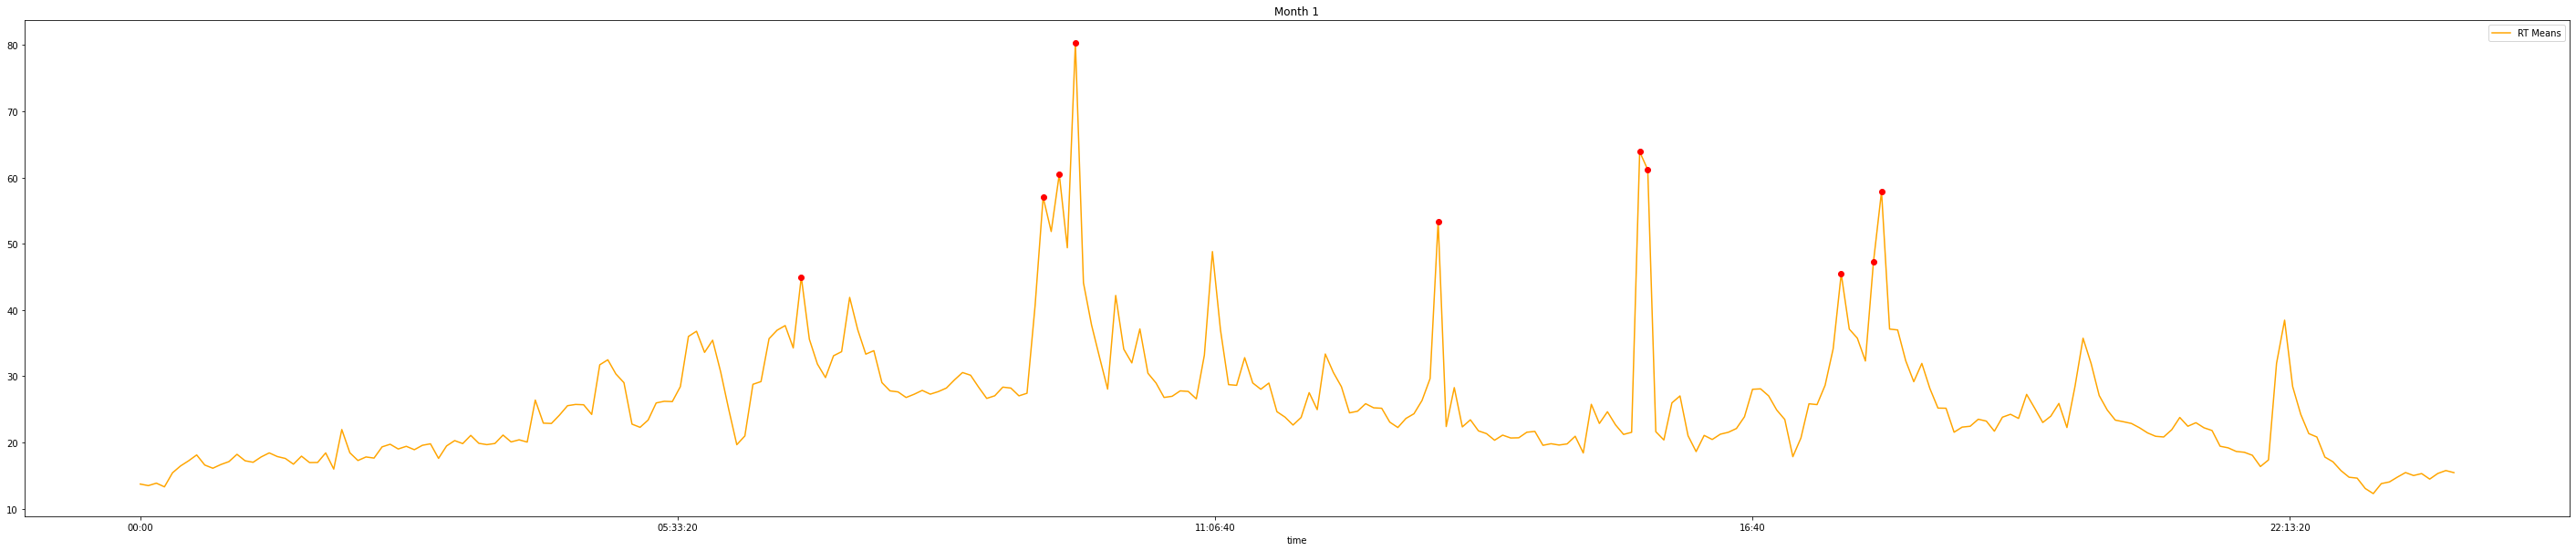

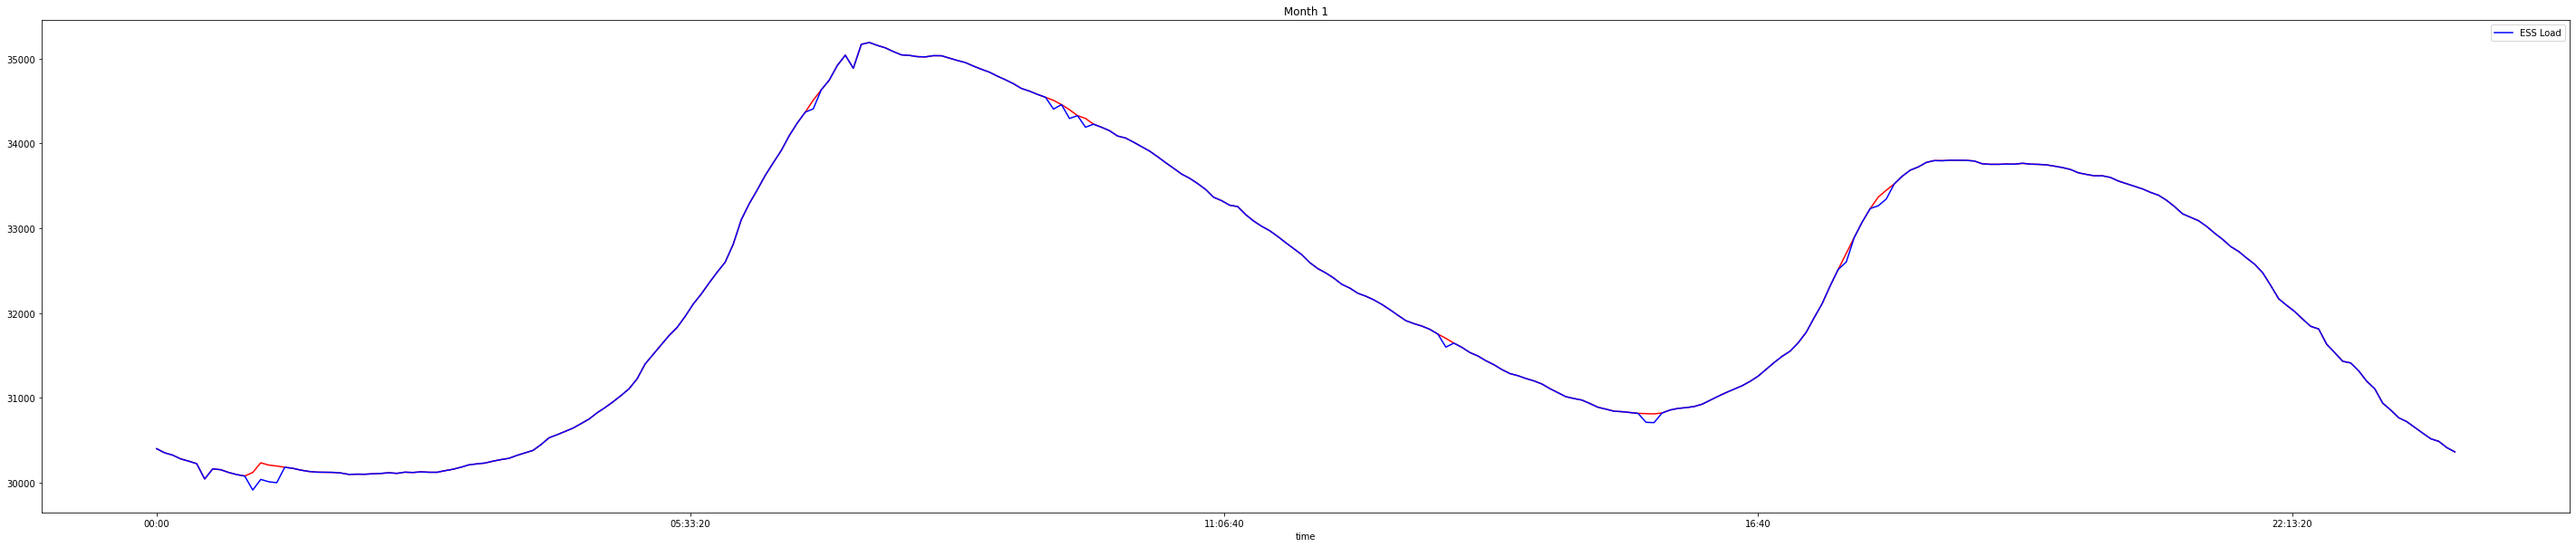

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


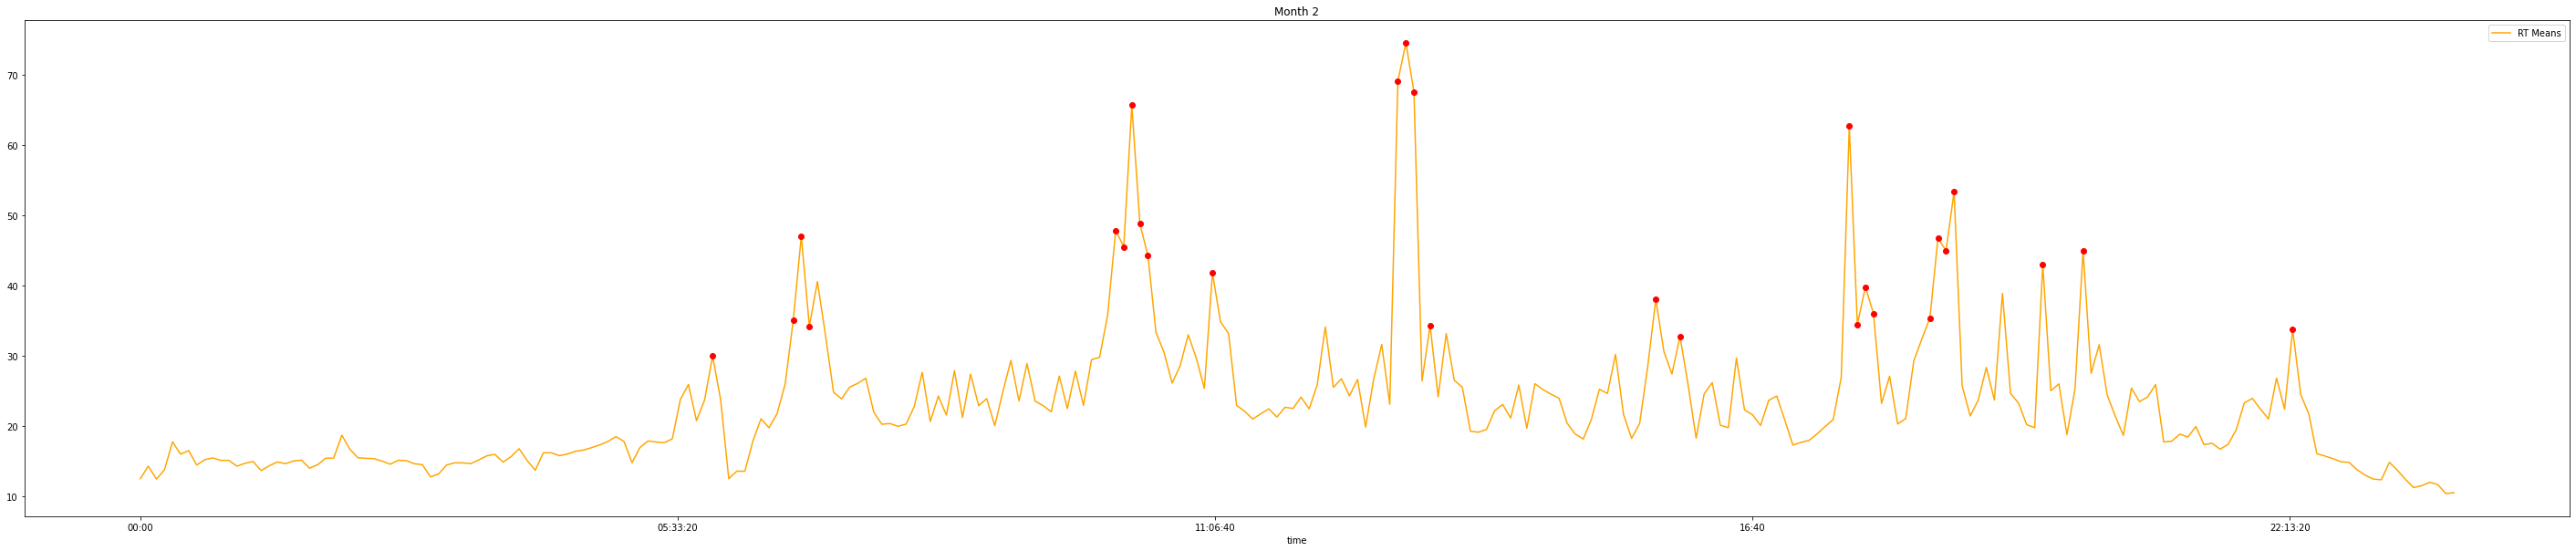

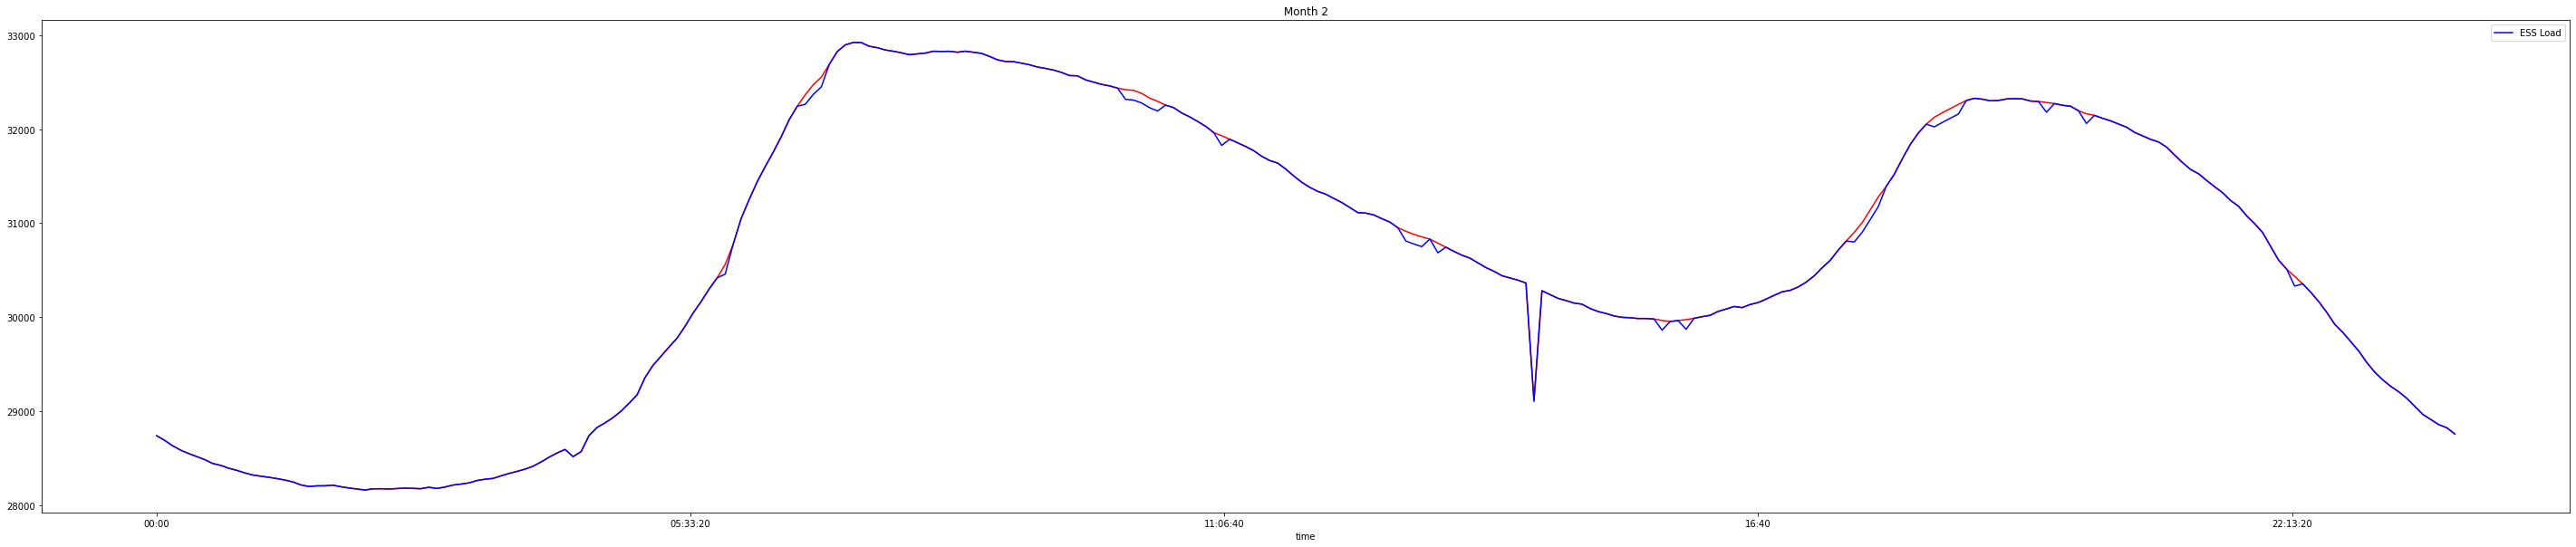

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


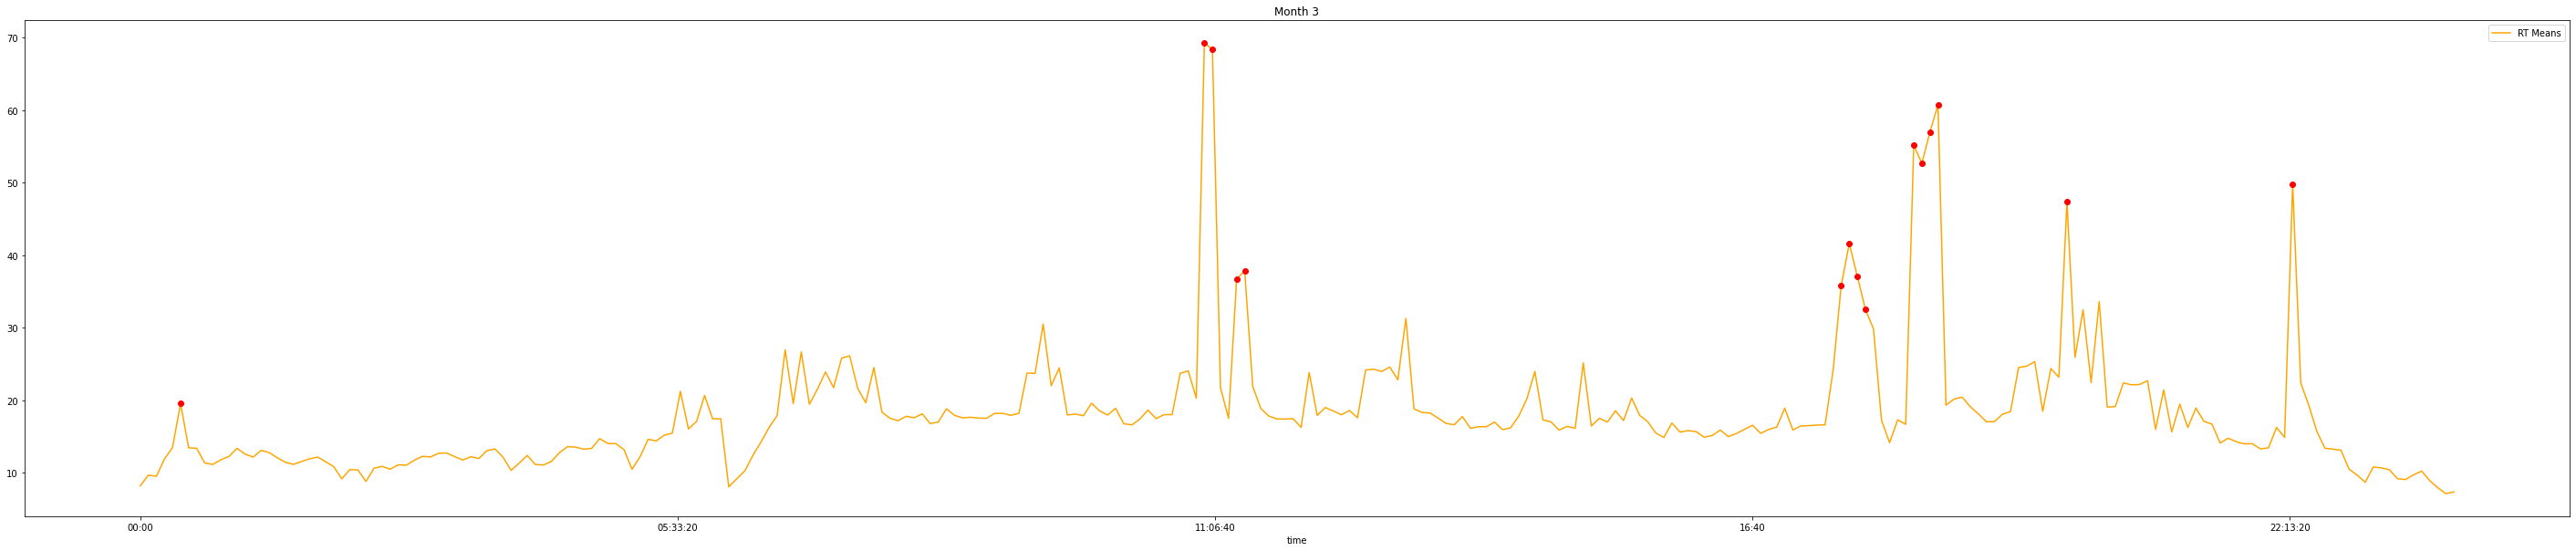

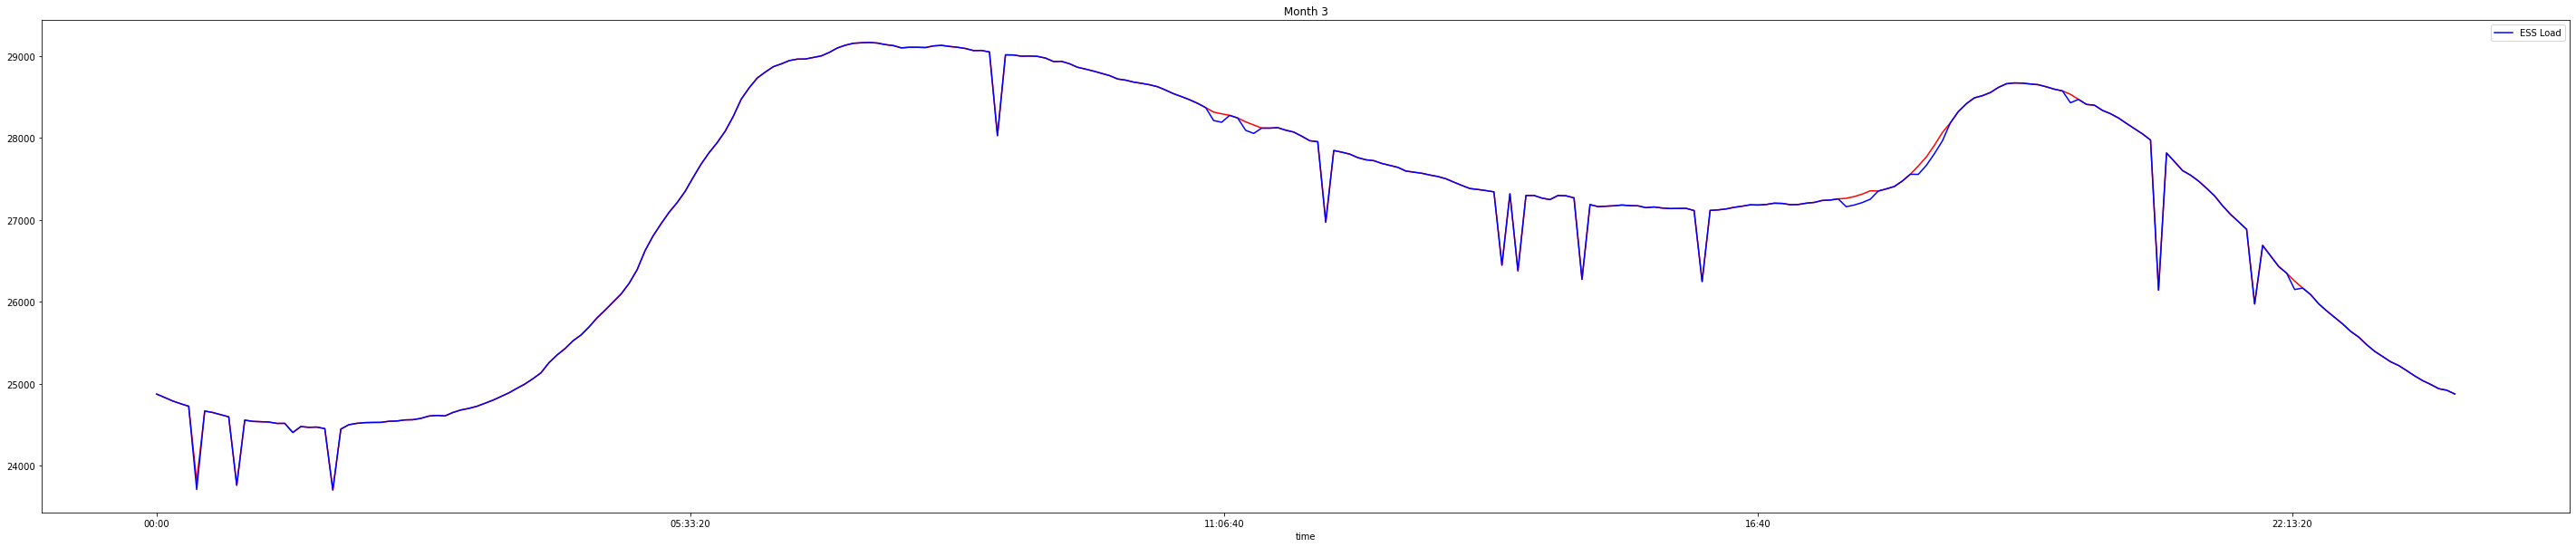

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


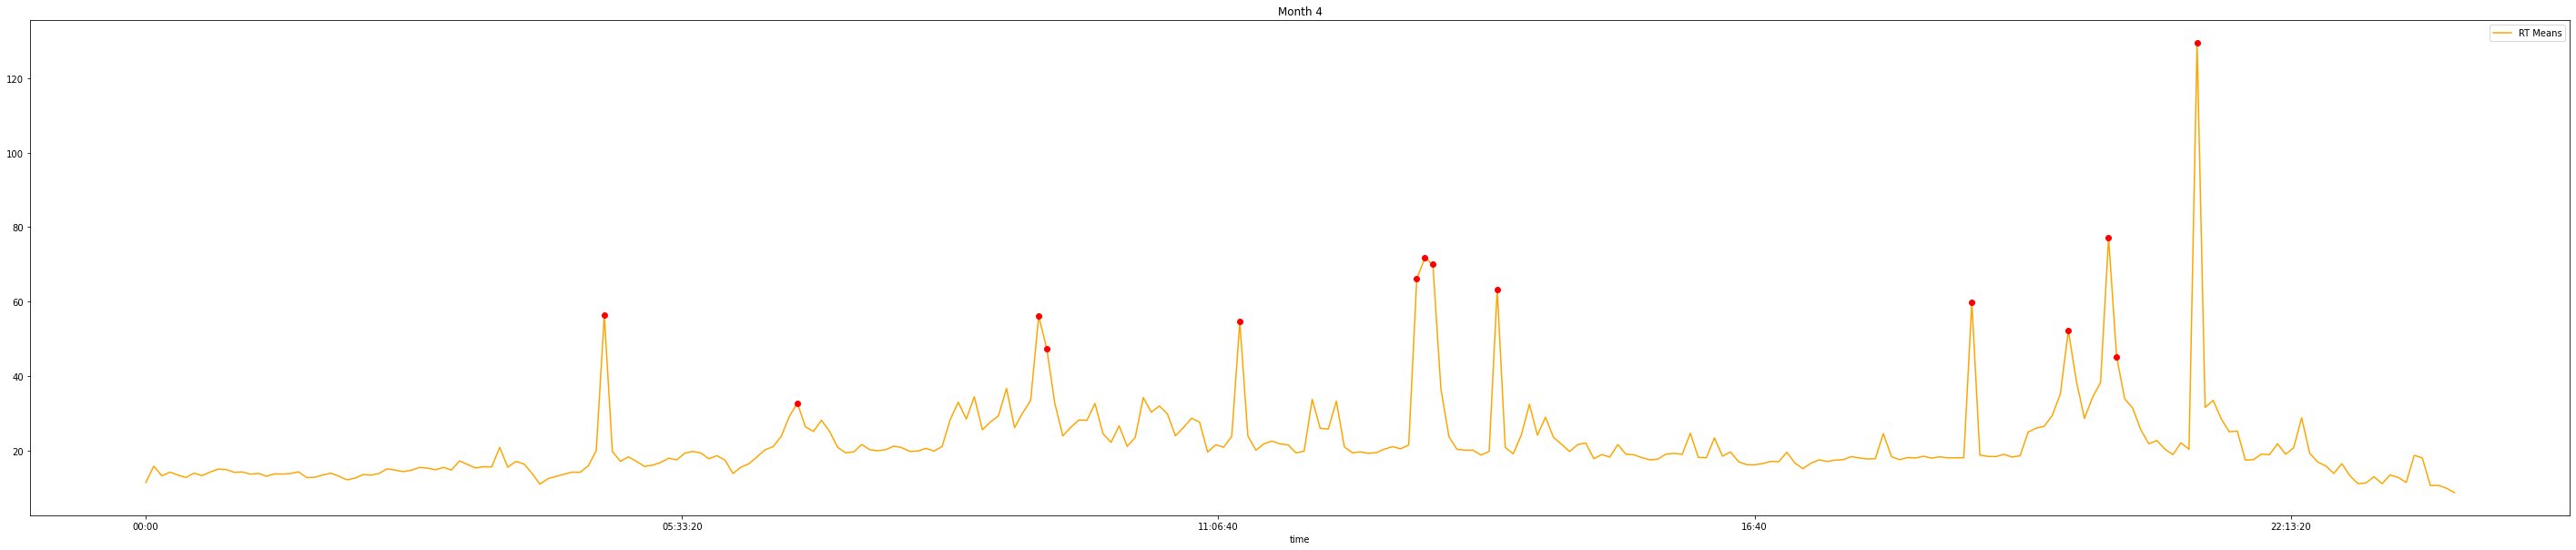

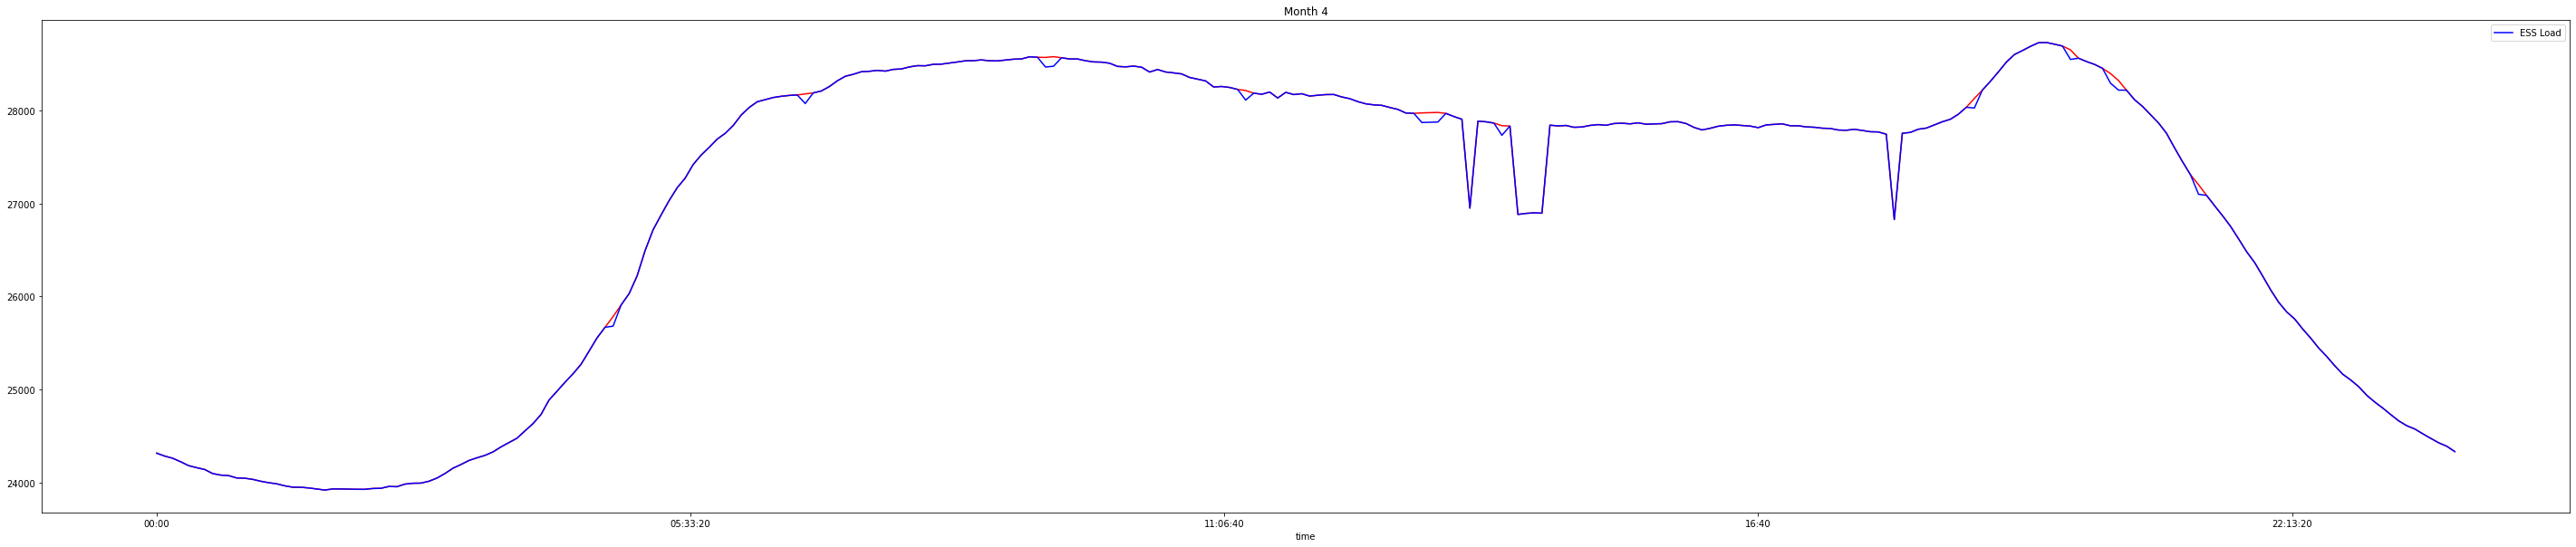

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


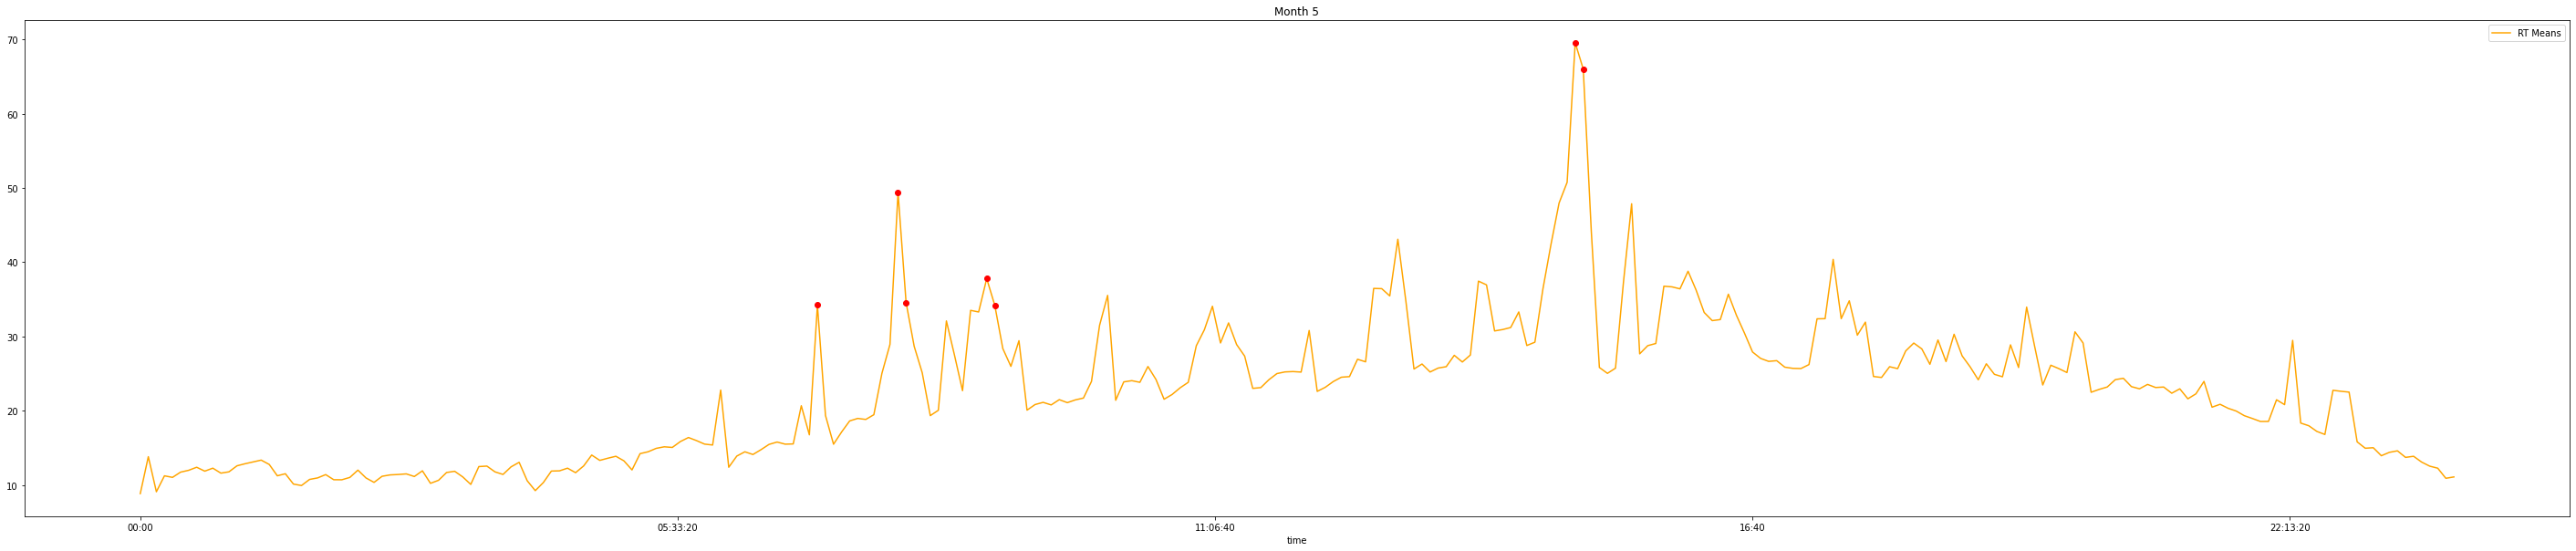

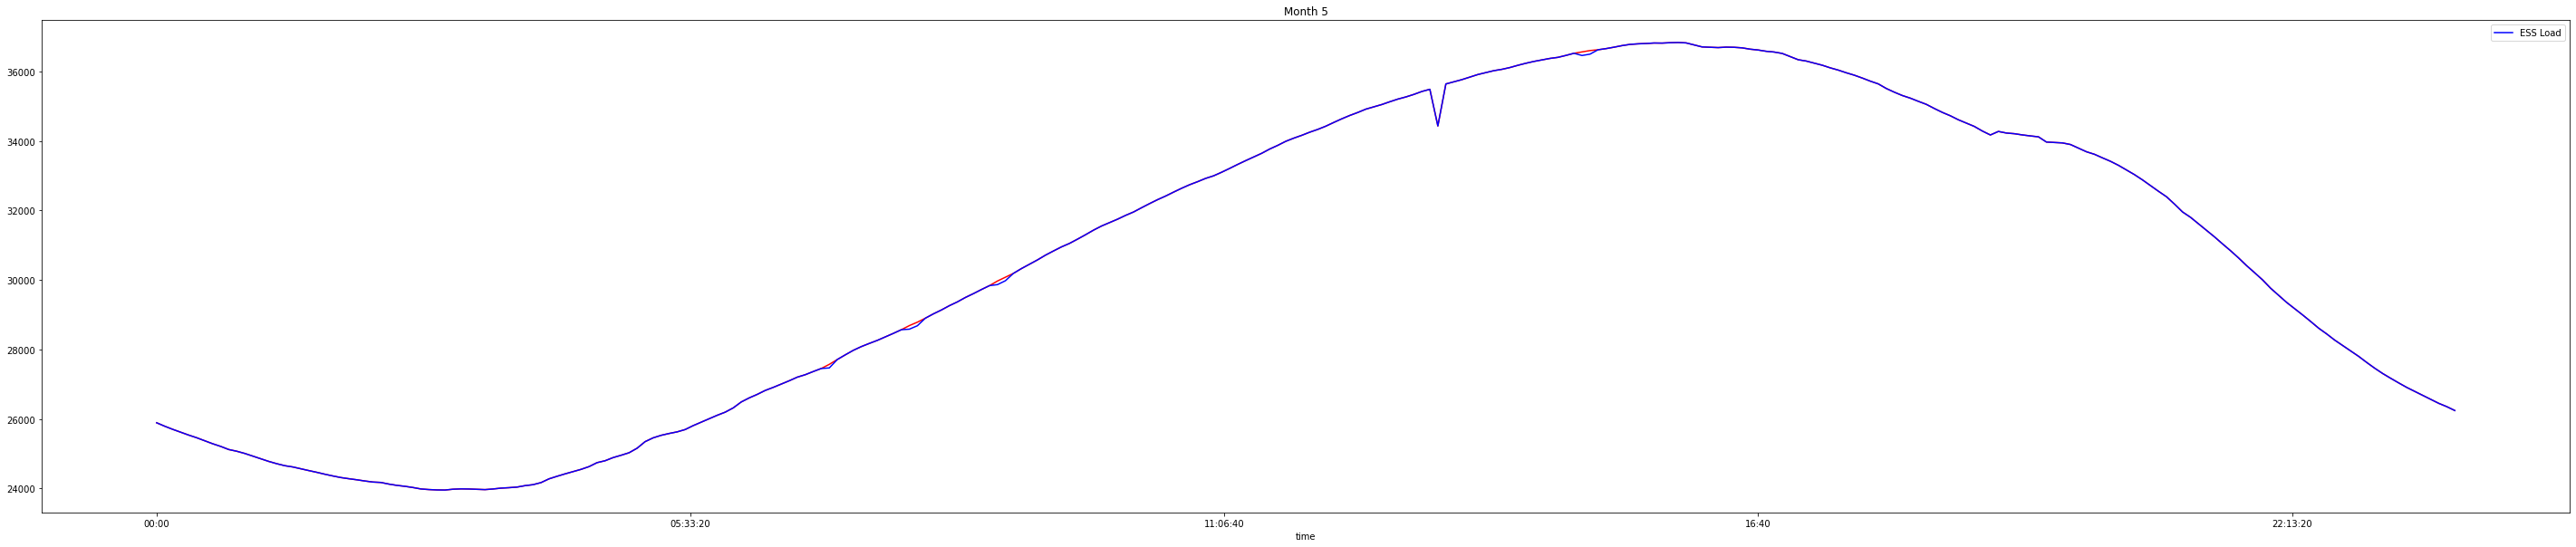

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


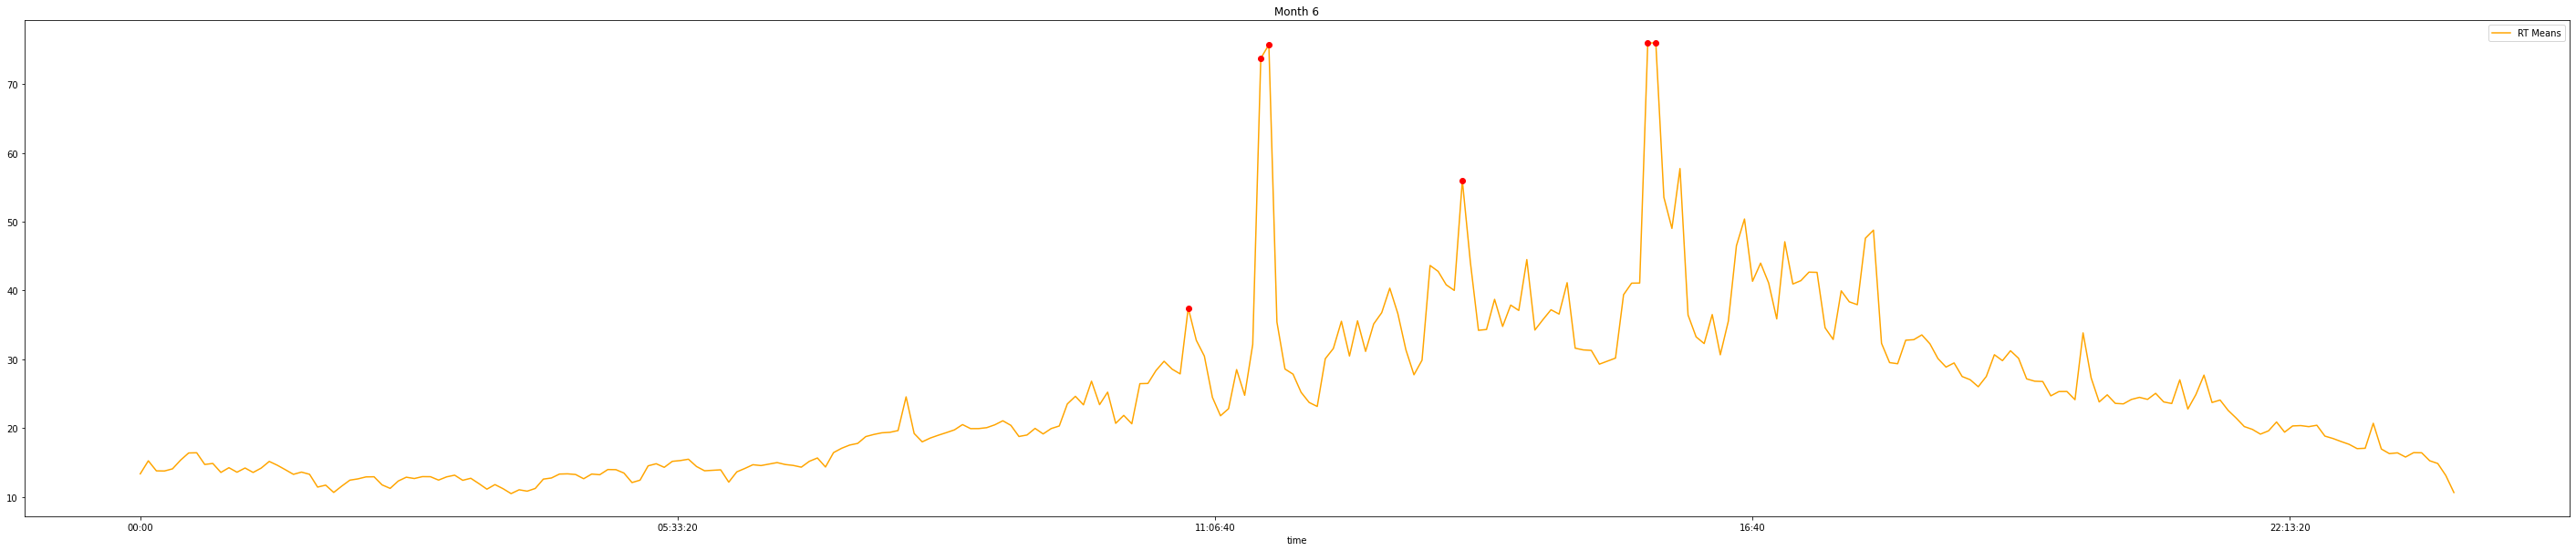

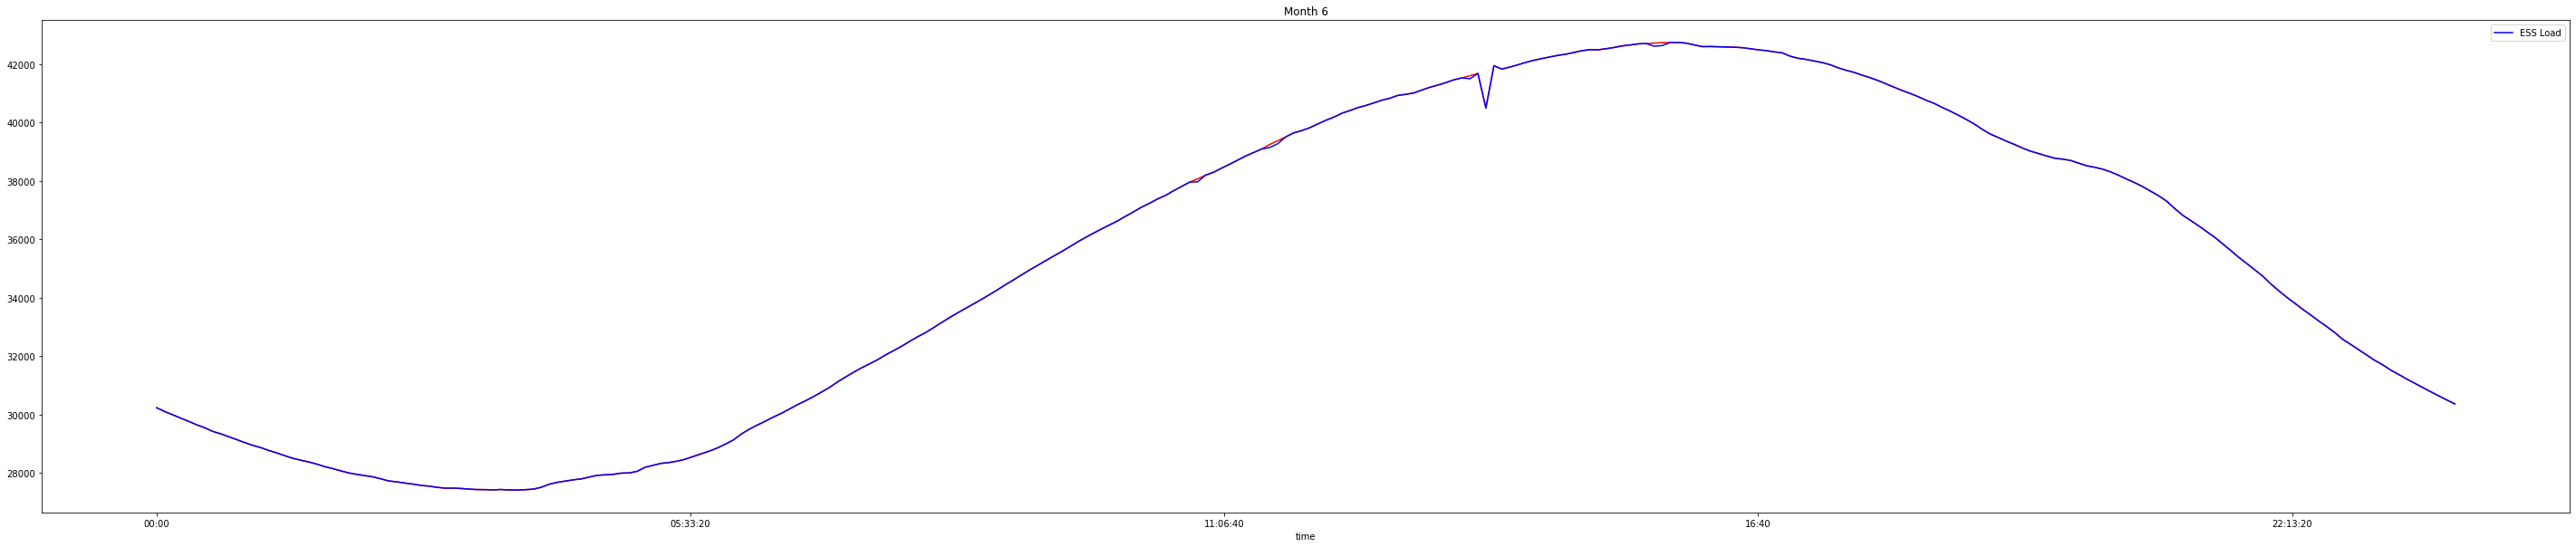

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


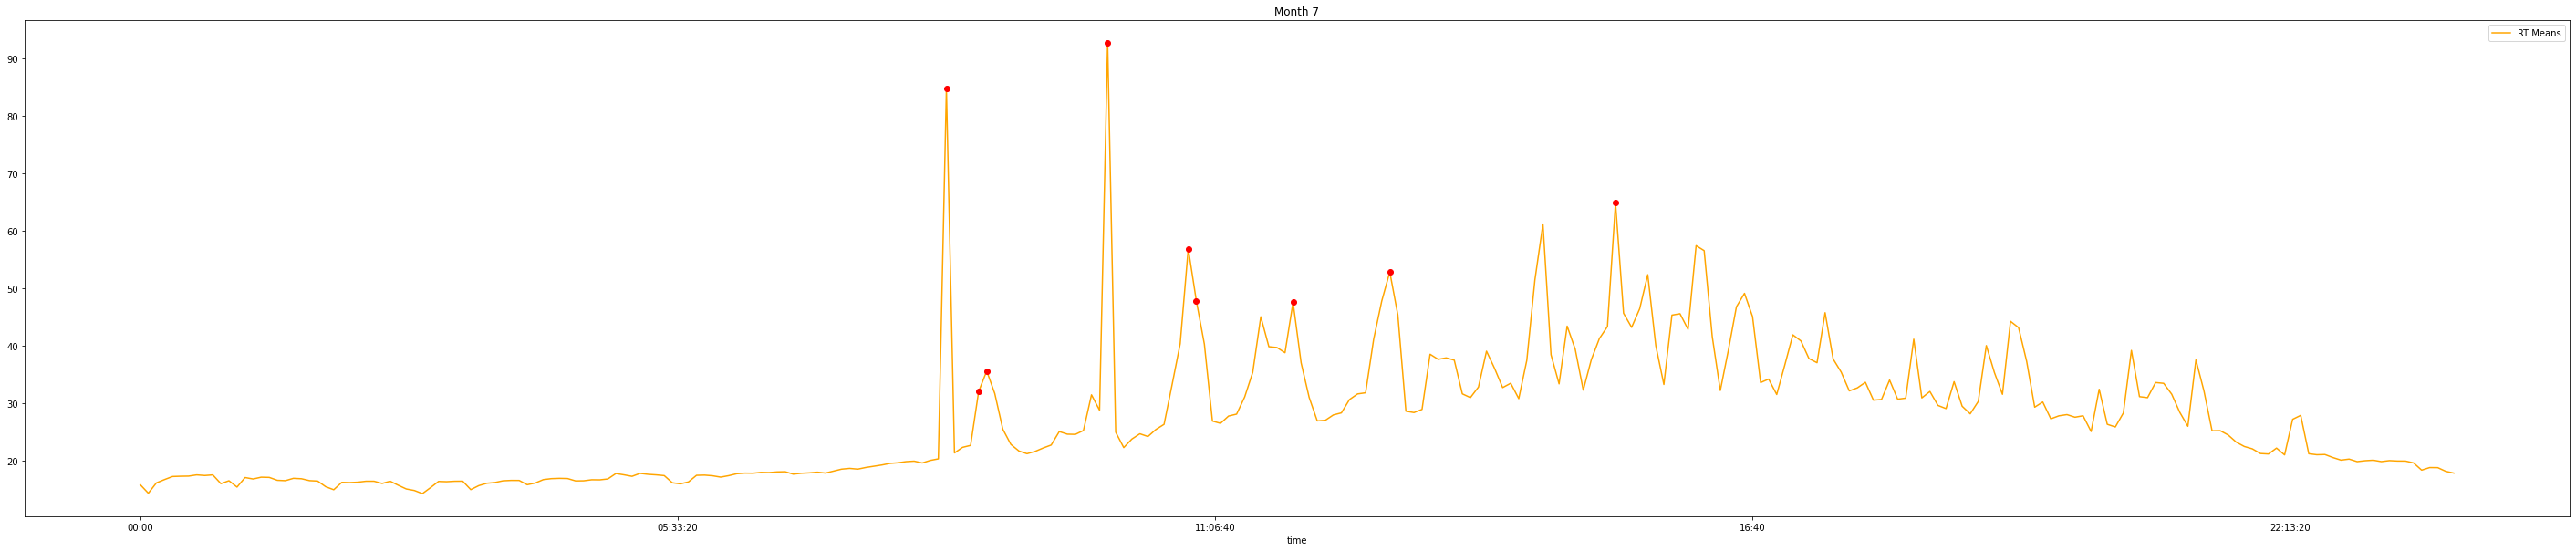

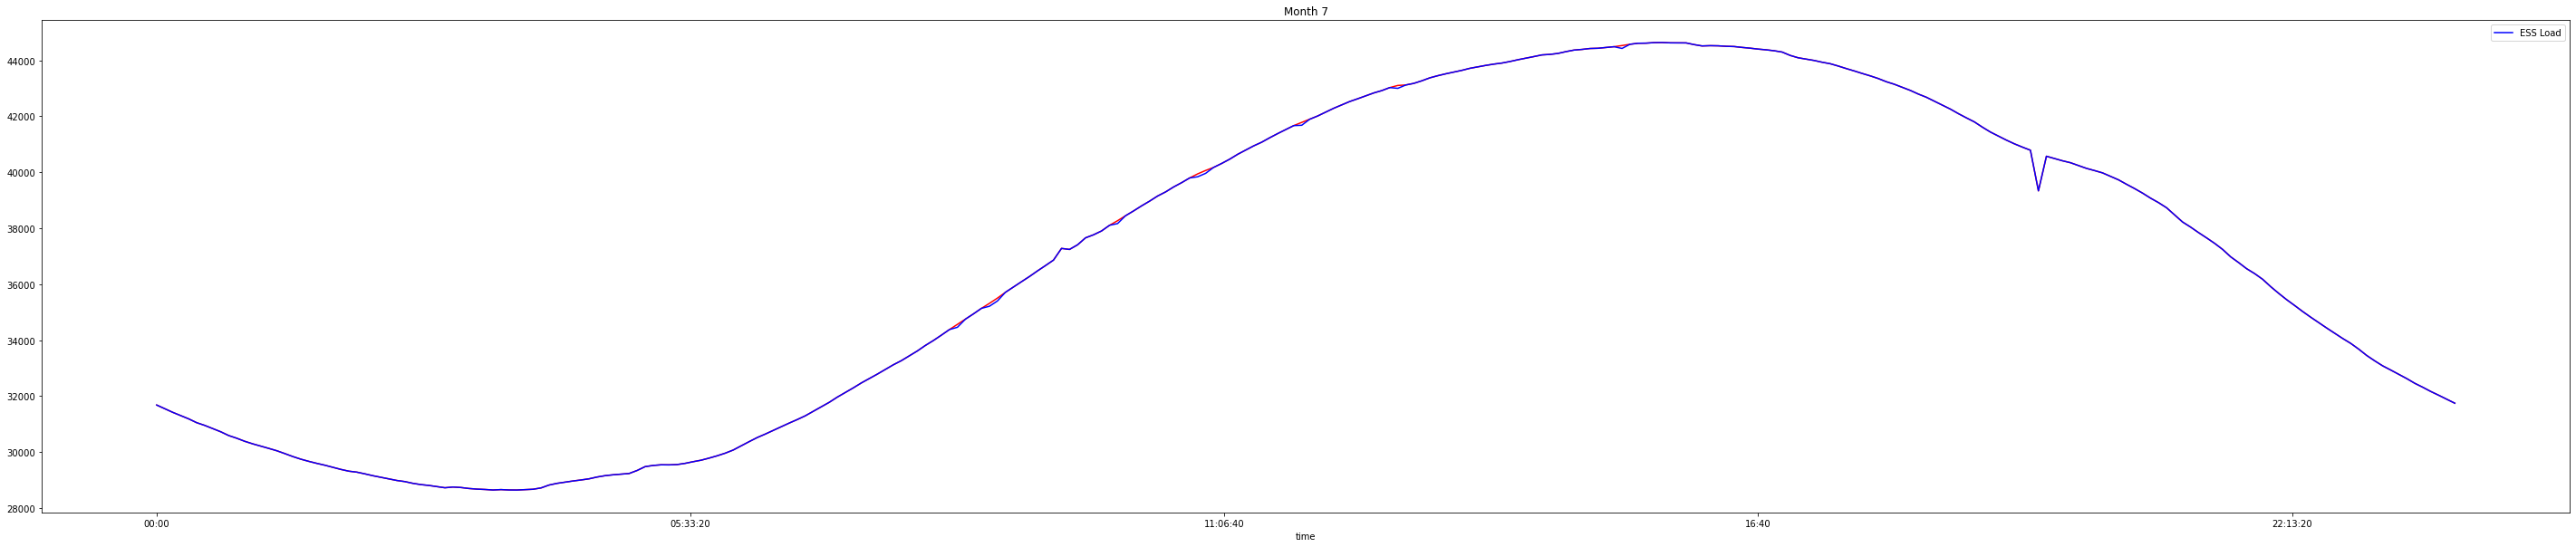

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


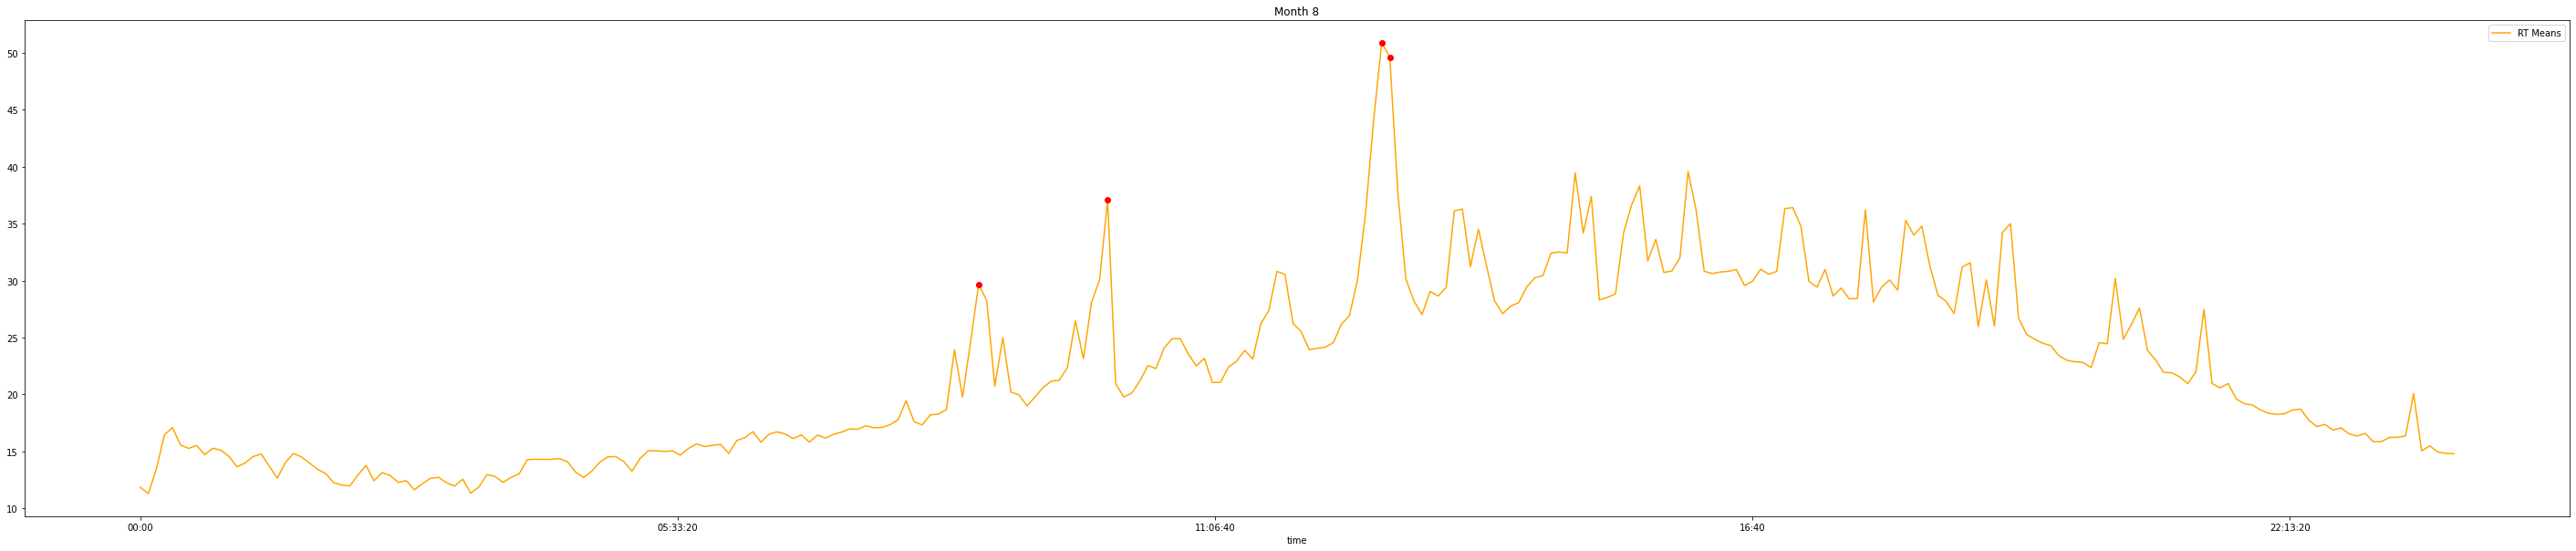

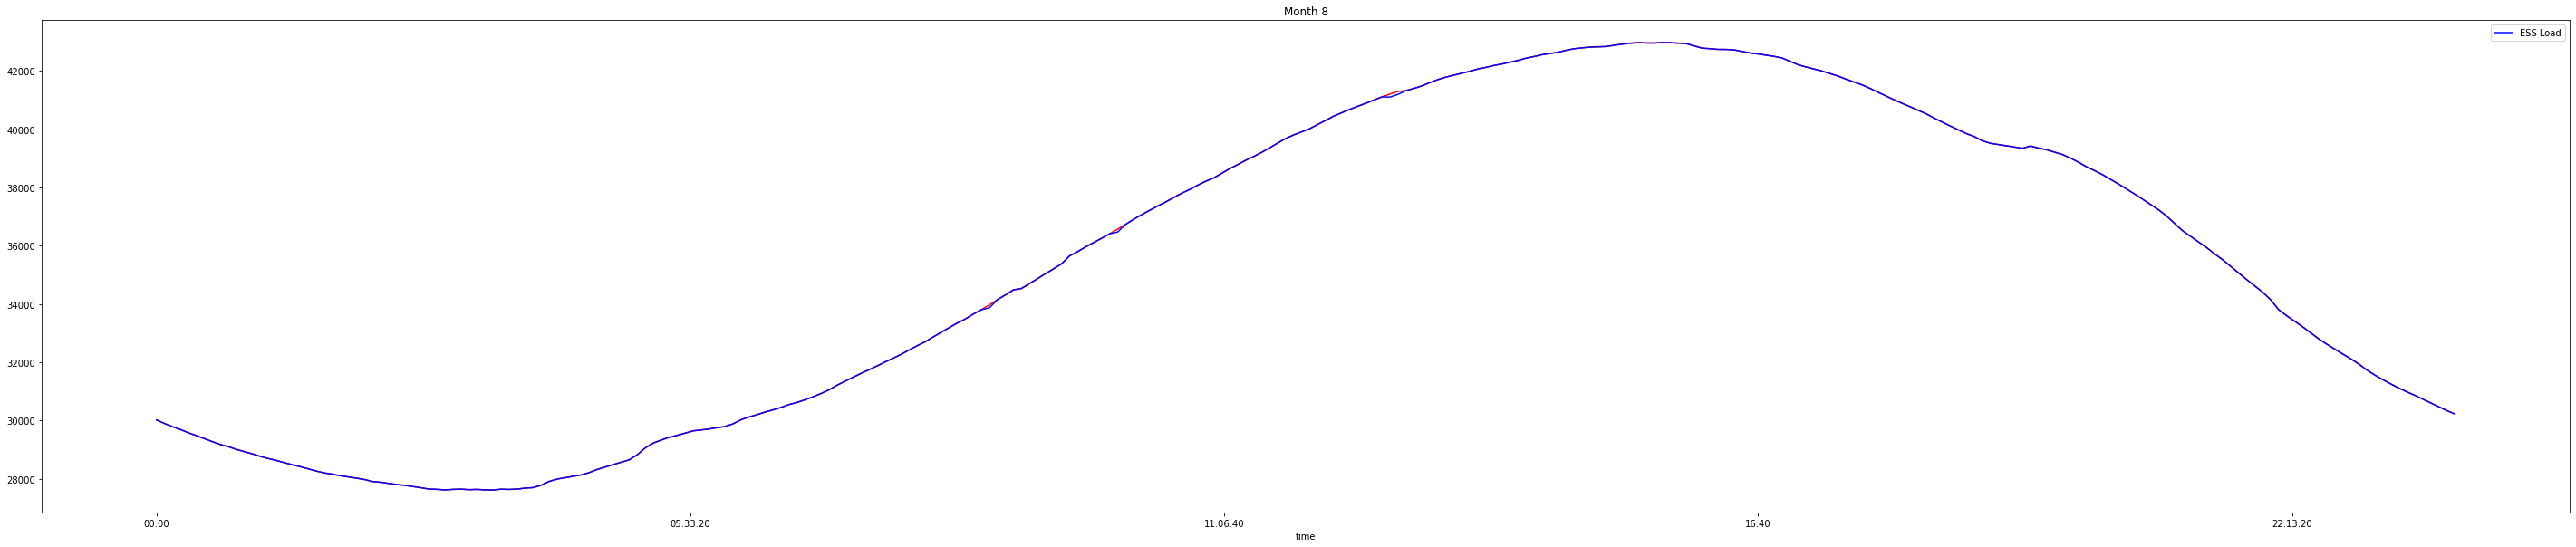

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


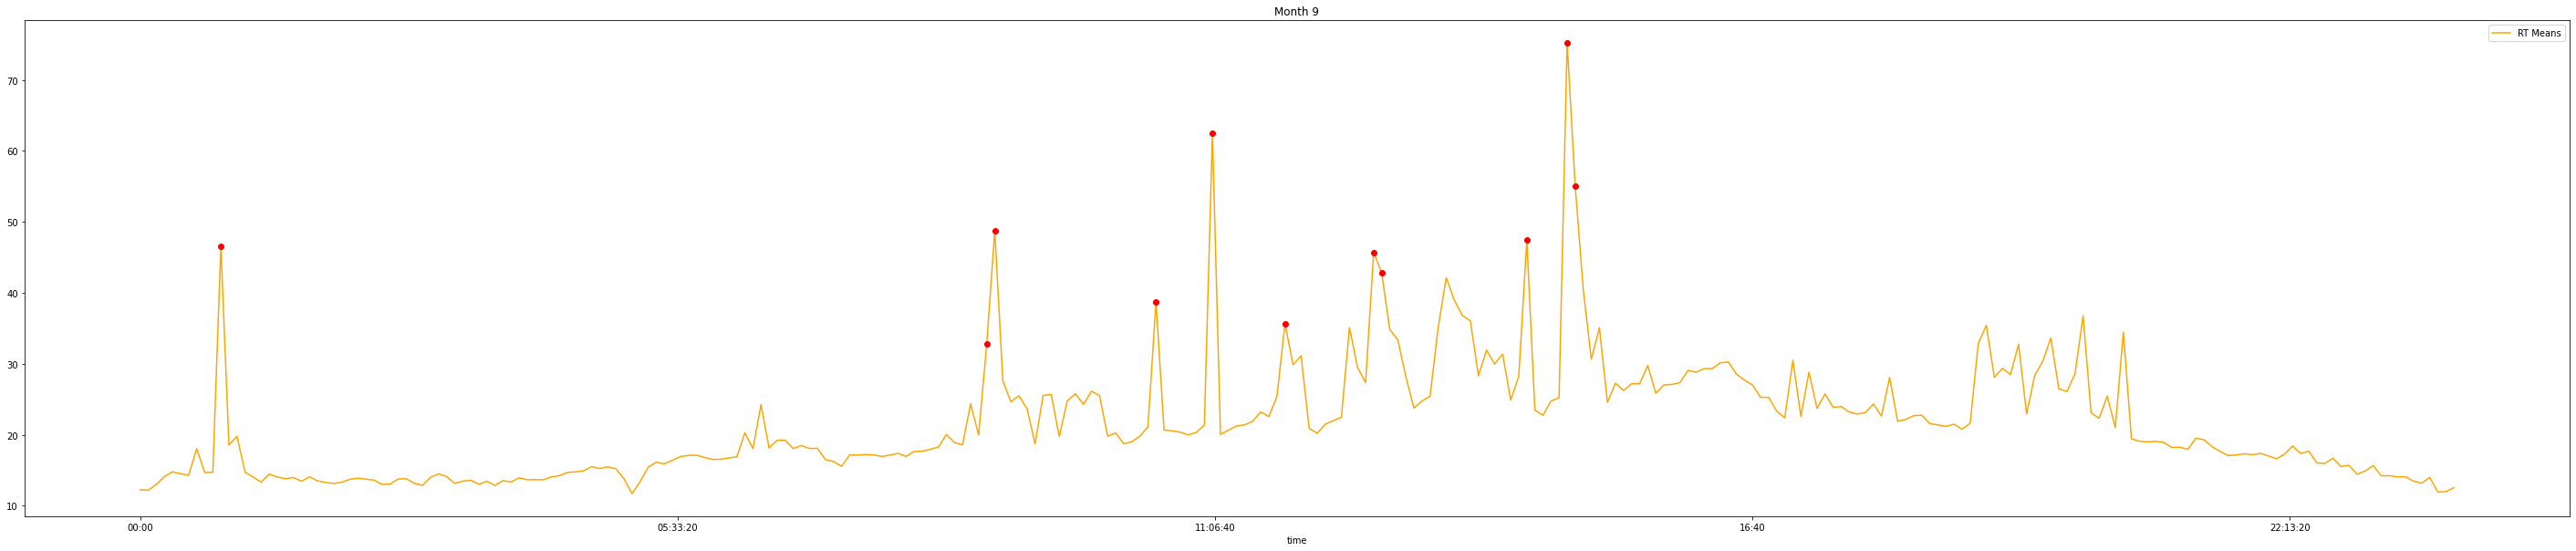

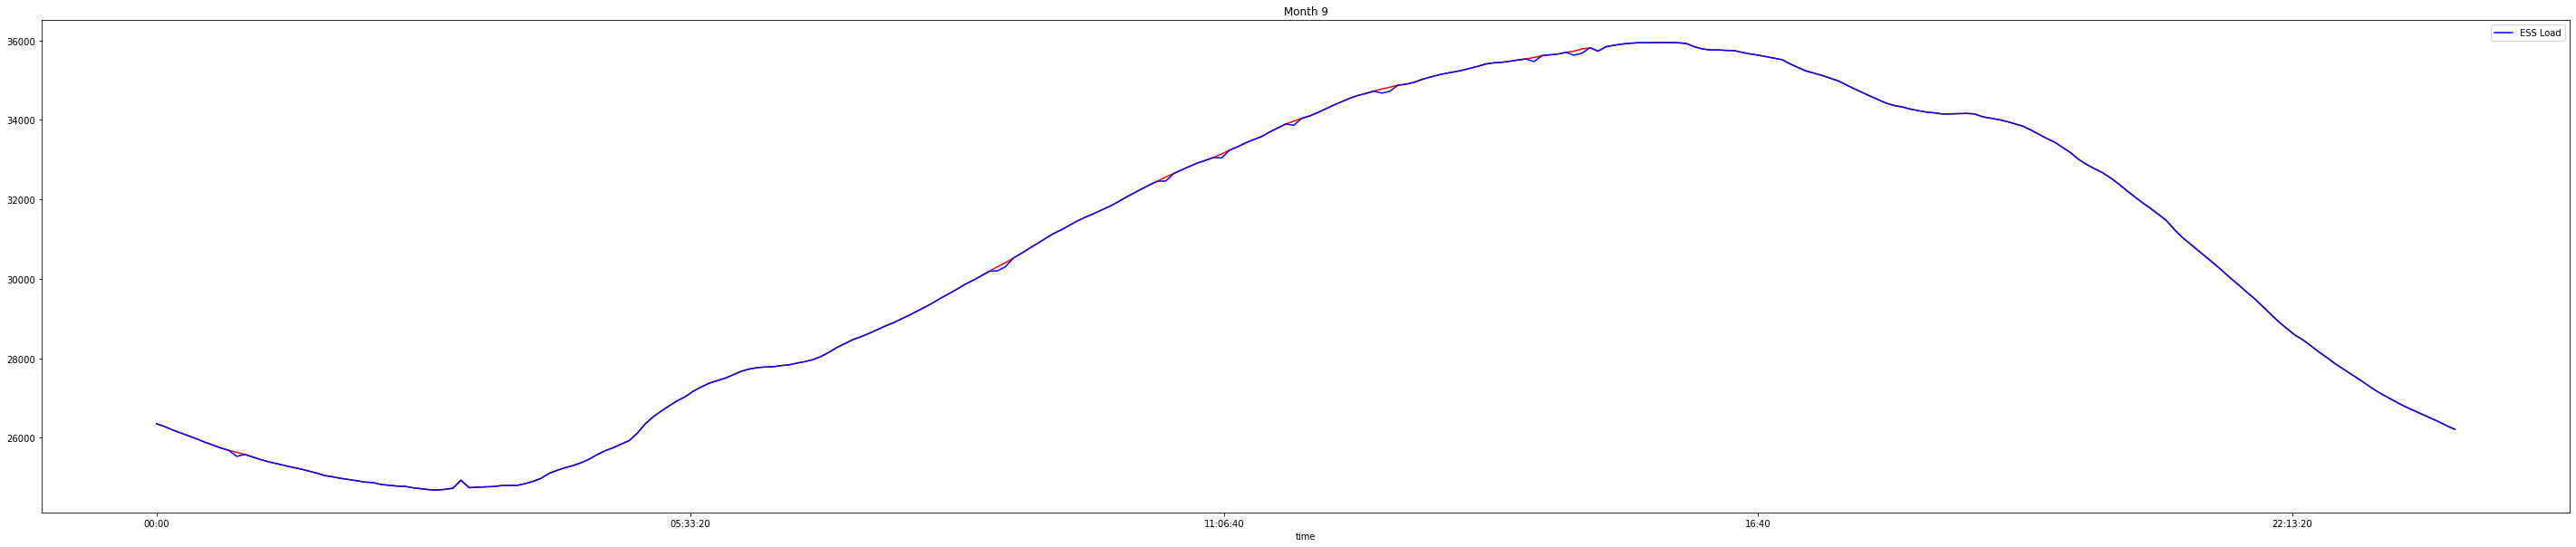

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


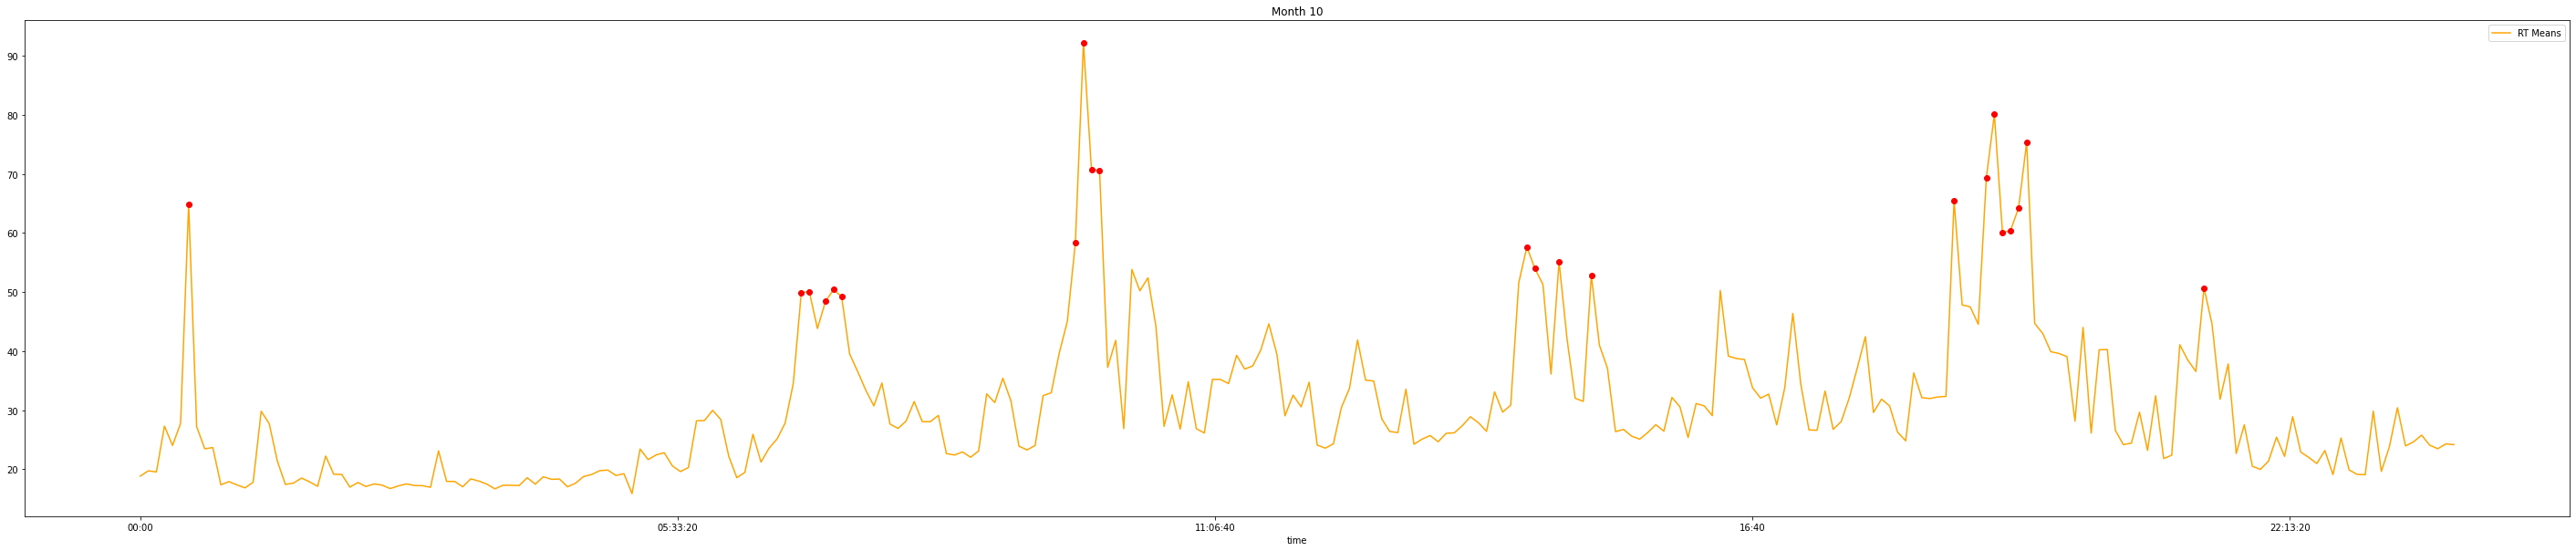

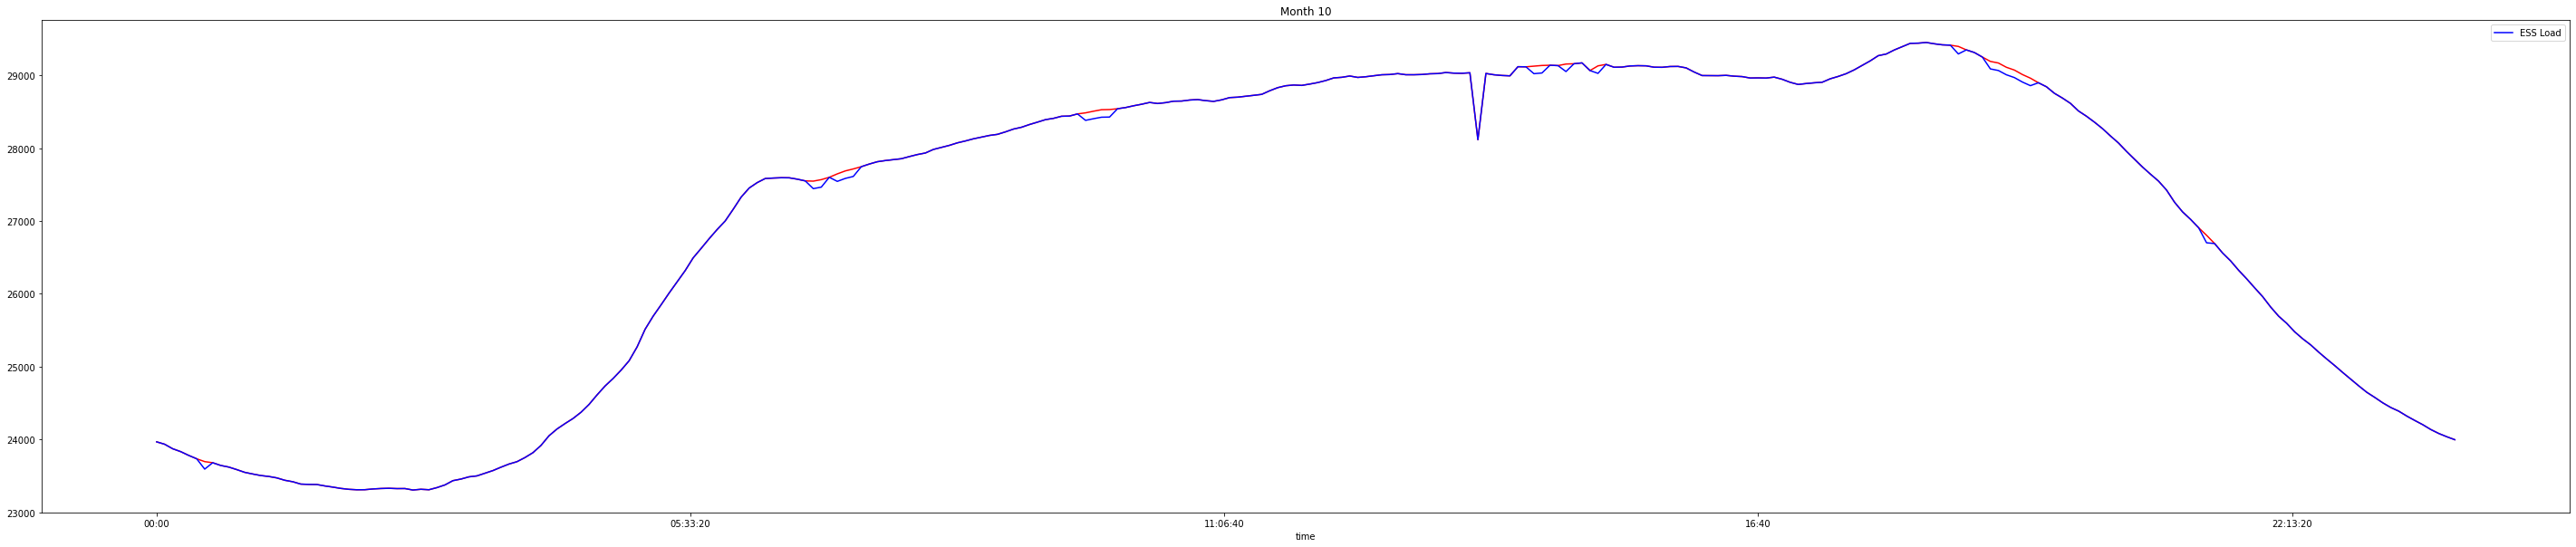

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


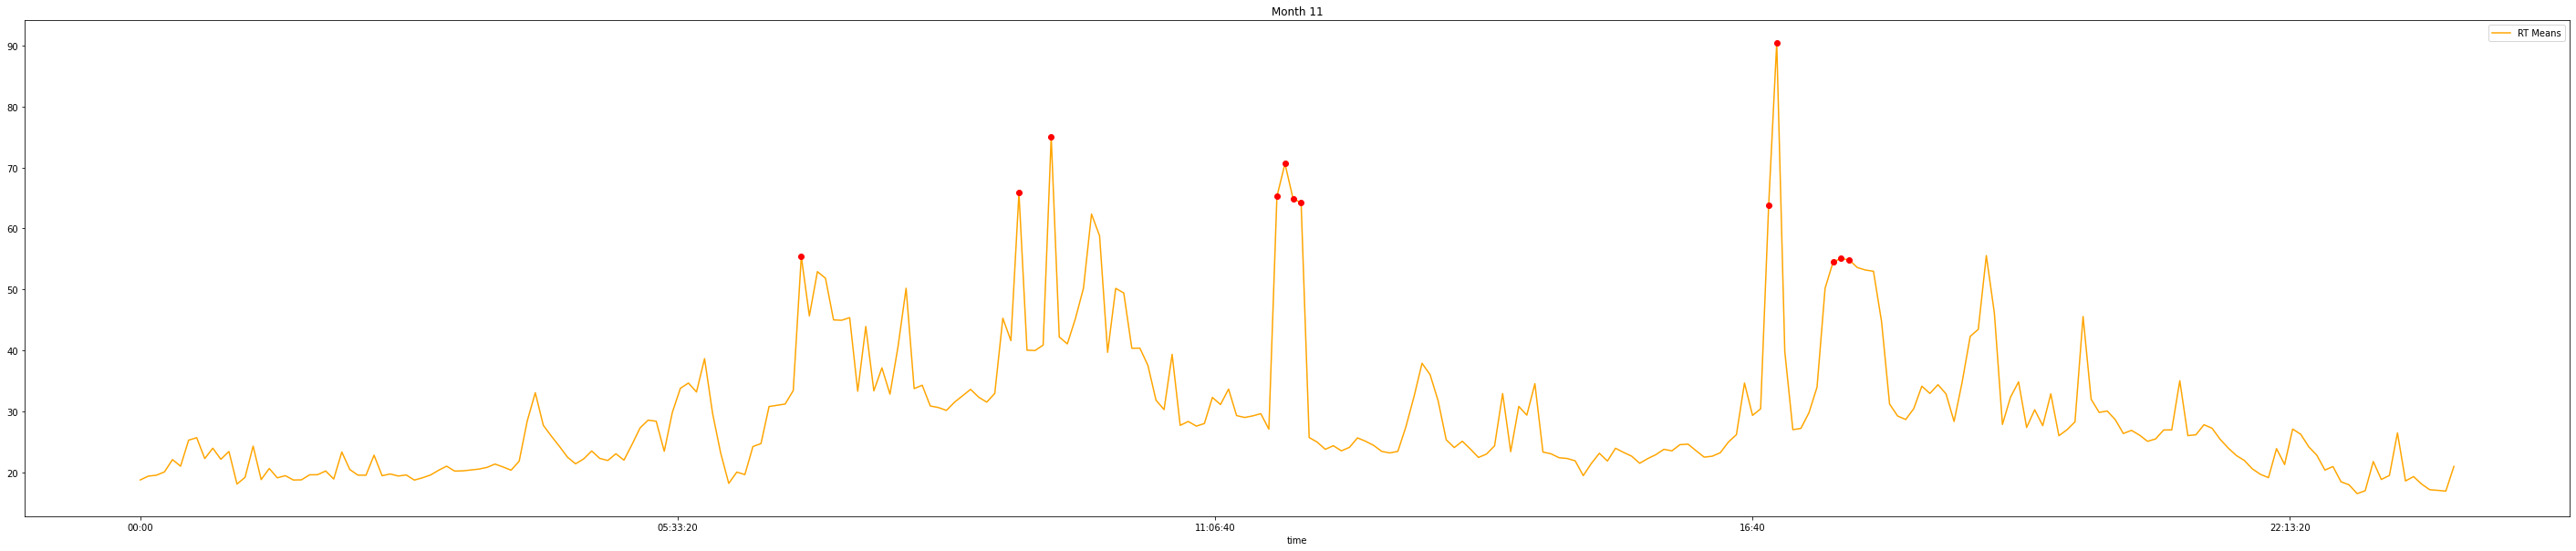

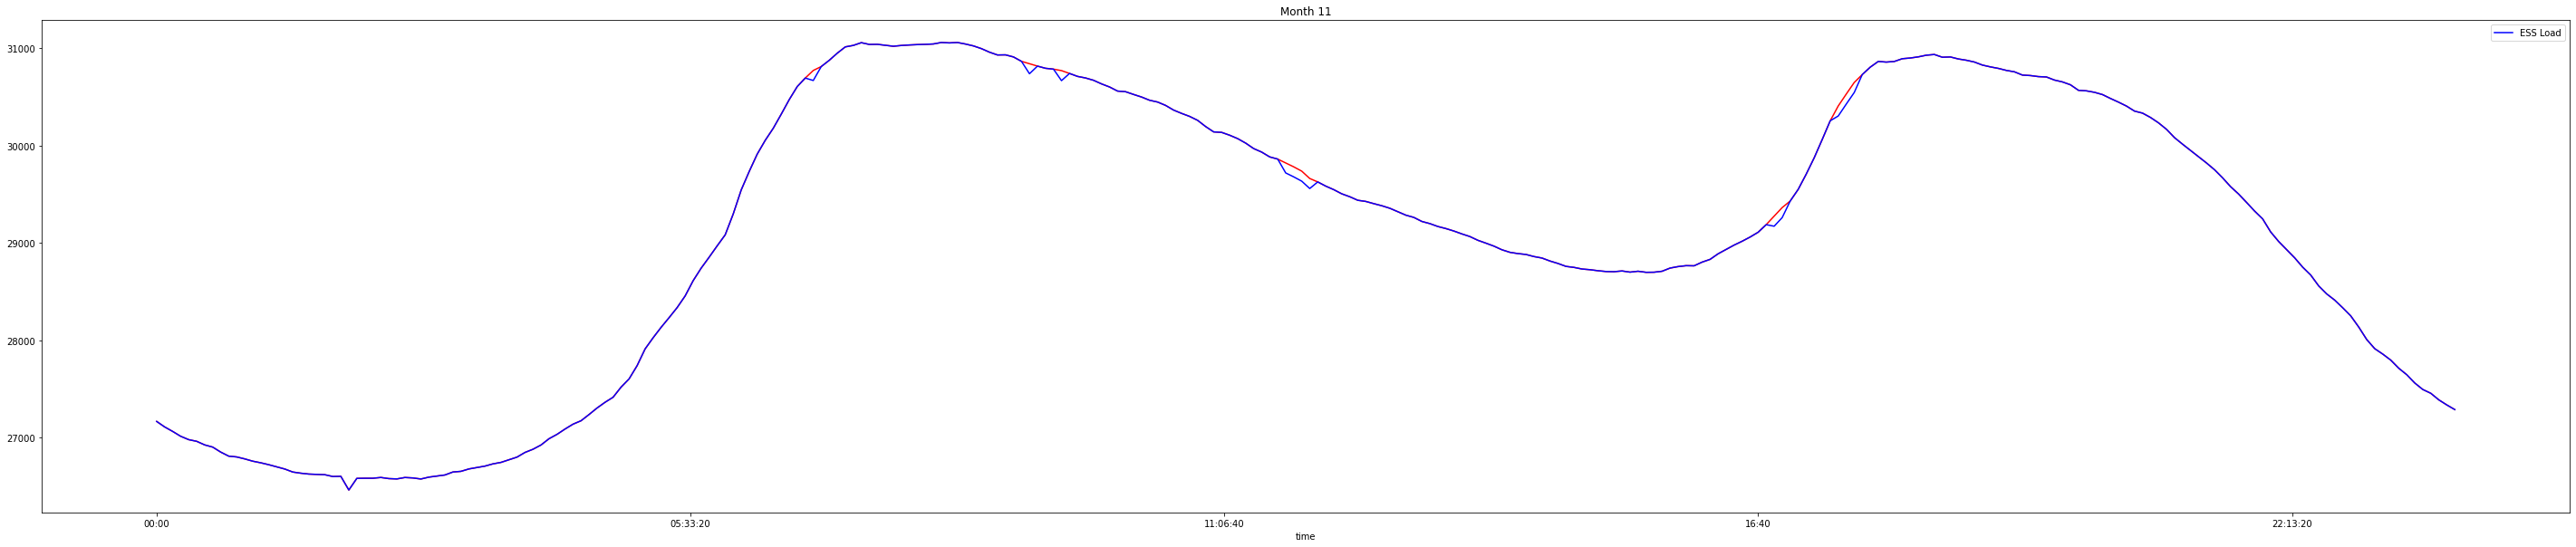

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


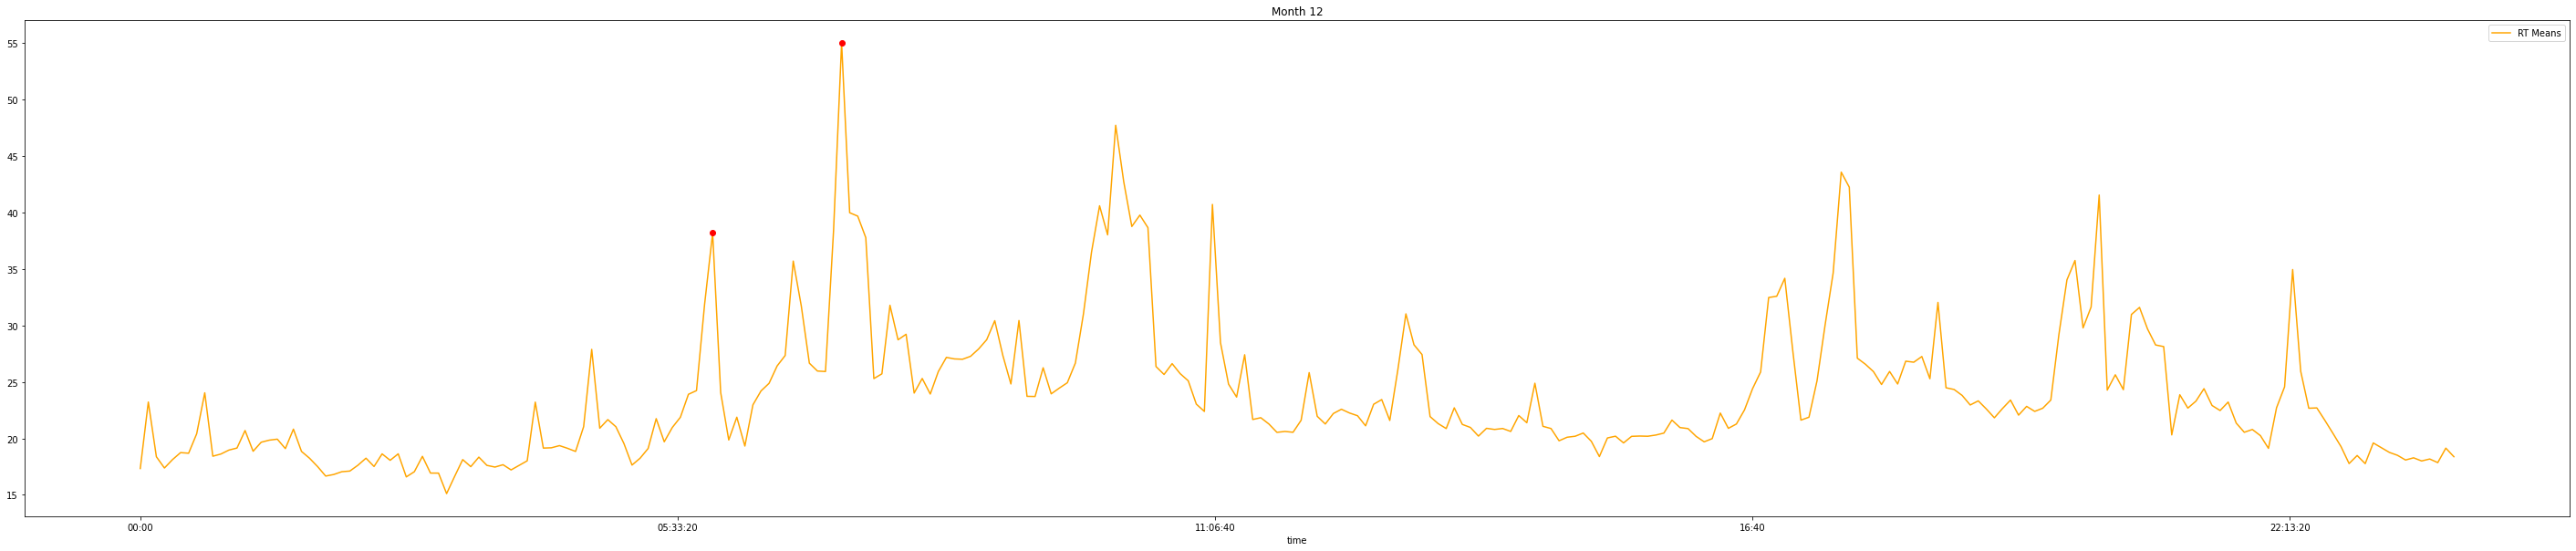

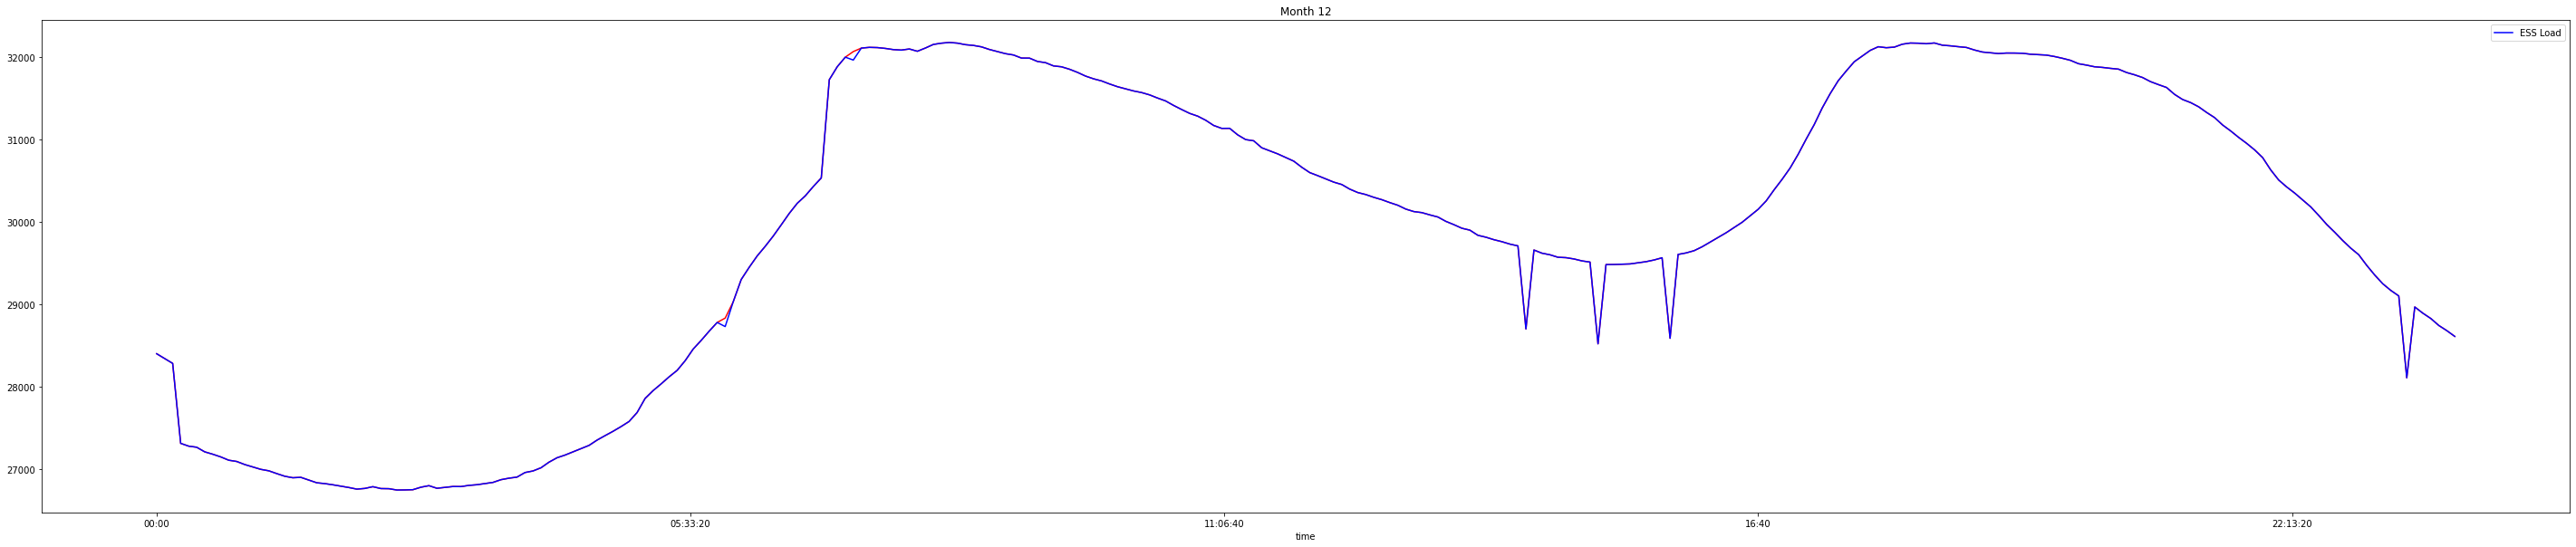

In [81]:
# Reducing loads at critical times

DART2018_ESS = DART2018_2
ESS_size = 103
months = []
for month in range(1,13):
    by_month = DART2018[DART2018['Month']==month]
    by_month_ESS = DART2018_ESS[DART2018_ESS['Month']==month]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()
    
    critical = crit_pts2(study)[0]
    for t in critical:
        by_month_ESS.loc[by_month_ESS['Local Time'] == t, 'Load'] -= ESS_size
    
    study2 = by_month_ESS.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()

    months.append(by_month_ESS)
    
    plt.title('Month {}'.format(month))
    plt.plot(study.index, study['LMP_RT'], 'orange', label='RT Means')
    plt.plot(crit_pts2(study)[0],crit_pts2(study)[1],'ro')
    plt.legend()
    plt.show()
    plt.plot(study.index, study['Load'], 'red')
    plt.plot(study2.index, study2['Load'], 'blue', label='ESS Load')
    plt.title('Month {}'.format(month))
    plt.legend()
    plt.show()
    
DART2018_ESS = pd.concat(months)

In [82]:
# Adding previous-interval and moving averages on updated dataset (with reduced load)

DART2018_ESS['Load_Diff'] = DART2018_ESS['Load'] - DART2018_ESS['DA Load']
DART2018_ESS['Spread'] = DART2018_ESS['LMP_DA'] - DART2018_ESS['LMP_RT']
DART2018_ESS = DART2018_ESS.rename(columns={' Wind':'Wind'})

DART2018_ESS_1 = DART2018_ESS.iloc[1:,:]
previous_load_diff = DART2018_ESS['Load_Diff'].iloc[0:-1].values
DART2018_ESS_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2018_ESS['LMP_RT'].iloc[0:-1].values
DART2018_ESS_1['Previous_RT'] = previous_RT
previous_spread = DART2018_ESS['Spread'].iloc[0:-1].values
DART2018_ESS_1['Previous_Spread'] = previous_RT

step = 3
previous_RT = DART2018_ESS_1['LMP_RT'].iloc[0:(DART2018_ESS_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2018_ESS_1['Load_Diff'].iloc[0:(DART2018_ESS_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2018_ESS_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2018_ESS_2 = DART2018_ESS_1.iloc[step:,:]
DART2018_ESS_2['Previous_RT_MA'] = previous_means_RT
DART2018_ESS_2['Previous_Load_Diff_MA'] = previous_means_load

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a c

#### Estimating price reduction due to 7-MW ESS

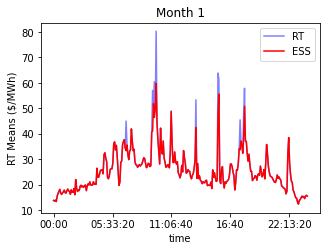

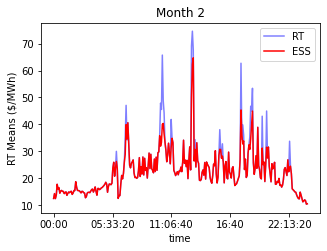

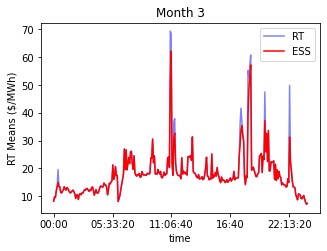

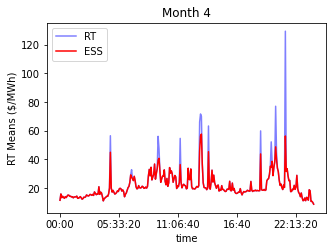

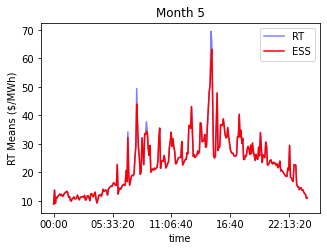

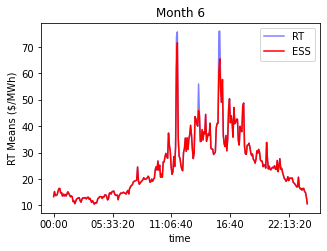

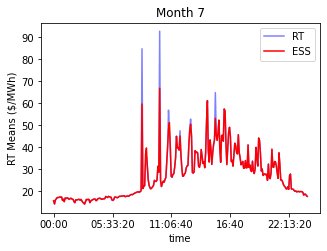

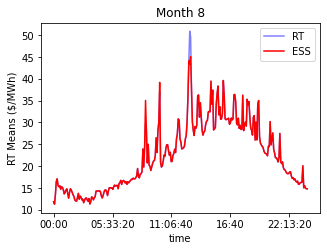

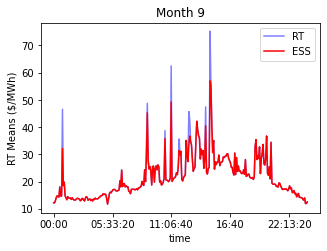

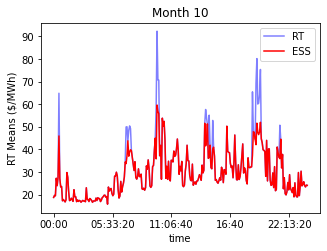

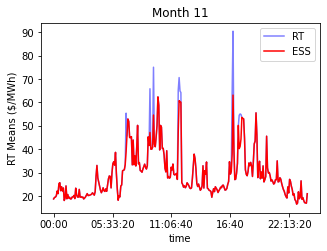

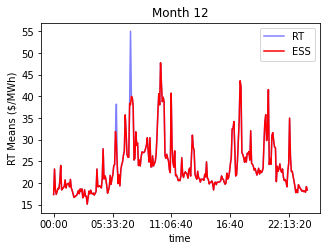

-18.952896

In [83]:


df = DART2018_2
df2 = DART2018_ESS_2
total_err = []

r2 = []
r2adj = []
for i in range(10):
    for j in range(1,13):
        by_month = df[df['Month']==j]
        study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_MA', 'Previous_RT_MA']].mean()
        study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
        study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()   

        by_month2 = df2[df2['Month']==j]
        study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_MA', 'Previous_RT_MA']].mean()
        study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
        study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std() 
        study2['ESS RT'] = study2['LMP_RT']

        critical = crit_pts2(study)[0]
        critical_df = study.loc[critical]
        result_peak = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_MA + Previous_RT + Previous_RT_MA""", data=critical_df).fit()
        r2.append(result_peak.rsquared)
        r2adj.append(result_peak.rsquared_adj)
        for hour in study.index:
            if hour in critical:
                if False == True:
                    study2['ESS RT'].loc[hour] = (
                                            study2['Previous_RT_MA'].loc[hour]*result_peak.params[10] +  
                                            study2['Previous_RT'].loc[hour]*result_peak.params[9] +
                                            study2['Previous_Load_Diff_MA'].loc[hour]*result_peak.params[8] + 
                                            study2['Previous_Load_Diff'].loc[hour]*result_peak.params[7] + 
                                            study2['Load_Diff'].loc[hour]*result_peak.params[6] + 
                                            study2['Wind'].loc[hour]*result_peak.params[5] + 
                                            study2['Load'].loc[hour]*result_peak.params[4] + 
                                            study2['DA_std'].loc[hour]*result_peak.params[3] + 
                                            study2['RT_std'].loc[hour]*result_peak.params[2] + 
                                            study2['LMP_DA'].loc[hour]*result_peak.params[1] + 
                                            result_peak.params[0])
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_MA'].loc[hour]*slopes_10['Previous_RT_MA'][0] +  
                                        study2['Previous_RT'].loc[hour]*slopes_10['Previous_RT'][0] +
                                        study2['Previous_Load_Diff_MA'].loc[hour]*slopes_10['Previous_Load_Diff_MA'][0] + 
                                        study2['Previous_Load_Diff'].loc[hour]*slopes_10['Previous_Load_Diff'][0] + 
                                        study2['Load_Diff'].loc[hour]*slopes_10['Load_Diff'][0] + 
                                        study2['Wind'].loc[hour]*slopes_10['Wind'][0] + 
                                        study2['Load'].loc[hour]*slopes_10['Load'][0] + 
                                        study2['DA_std'].loc[hour]*slopes_10['DA_std'][0] + 
                                        study2['RT_std'].loc[hour]*slopes_10['RT_std'][0] + 
                                        study2['LMP_DA'].loc[hour]*slopes_10['LMP_DA'][0] + 
                                        slopes_10['Intercept'][0])            
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
        if i == 0:
            fig, ax = plt.subplots(figsize=[5,3.5])
            ax.plot(study2.index, study2['LMP_RT'], 'blue', label='RT', alpha=0.5)
            ax.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
            plt.title('Month {}'.format(j))
            plt.ylabel('RT Means ($/MWh)')
            ax.legend()
            plt.show()
    
round(np.array(total_err).mean(),6)

In [84]:
round(np.array(total_err).mean(),6)

-18.952896

#### Bayesian optimization of ORT hyper-parameters

In [37]:
dataset = DART2018_2.loc[:,['LMP_DA','Load','Wind','Previous_RT_MA','Load_Diff','Hour','Day','LMP_RT','Minute of Day']]
hours = []
for time in dataset['Hour']:
    hours.append(time.hour)
dataset['Hour'] = np.array(hours)

train_days = random.sample(range(1,32), 15)
train = dataset.loc[dataset['Day'].isin(train_days)].dropna()
test = dataset.loc[~dataset['Day'].isin(train_days)].dropna()

train.index = train['Minute of Day']
X = train.iloc[:,0:6]
y = train.iloc[:,7]

X_test = test.iloc[:,0:6]
y_test = test.iloc[:,7]

In [38]:
def xgb_loss(next_x):
    train_days = random.sample(range(1,32), 15)
    train = dataset.loc[dataset['Day'].isin(train_days)].dropna()
    test = dataset.loc[~dataset['Day'].isin(train_days)].dropna()

    X = train.iloc[:,0:6]
    y = train.iloc[:,7]
    X_test = test.iloc[:,0:6]
    y_test = test.iloc[:,7]
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = next_x[0], max_depth = next_x[1], 
                              learning_rate = next_x[2], alpha = next_x[3], colsample_bytree = next_x[4],
                             min_child_weight = next_x[5])
    xg_reg.fit(X, y)
    y_xgb = xg_reg.predict(X_test)
    return pe(y_xgb, y_test)[pe(y_xgb, y_test)!=np.inf].mean()

In [39]:
def optimize(dimensions, start_points, times, function):

    start_points, times = int(start_points), int(times)
    # initial_point_generator, njobs not found
    opt = Optimizer(list(dimensions.values()), base_estimator="gp", n_initial_points=start_points,
                    acq_func="gp_hedge", acq_optimizer="auto", random_state=0)

    loss_vector = np.zeros(times)
    params_list = []
    for j in range(len(opt.ask())):
        params_list.append(list())
    best_loss = 1e10
    for i in range(times):
        next_x = opt.ask()
        loss = function(next_x)
        res = opt.tell(next_x, loss)
        loss_vector[i] = loss
        for p in range(len(next_x)):
            params_list[p].append(next_x[p])
        if loss < best_loss:
            best_loss = loss
            best_params = next_x
        print(f"\rOptimization {100 * (i+1)/times}% completed. Best loss: {best_loss:.4}   ", end="")
    return best_loss, best_params, loss_vector, params_list

dimensions = {'n_estimators': Integer(1, 20, prior='uniform'),
              'max_depth': Integer(1, 5, prior='uniform'),
              'learning_rate': Real(0.1, 0.9, prior='uniform'),
              'alpha': Integer(5, 50, prior='uniform'),
              'colsample_bytree': Real(0.2, 0.8, prior='uniform'),
              'min_child_weight': Integer(1,100, prior='log-uniform')}

loss, params, loss_vector, params_vector = optimize(dimensions, 1e5, 1e3, xgb_loss)

Optimization 100.0% completed. Best loss: 936.9      

In [40]:
loss_df = pd.DataFrame({'PE':loss_vector,
                       'n_estimators':params_vector[0],
                       'max_depth':params_vector[1],
                       'learning_rate':params_vector[2],
                       'alpha':params_vector[3],
                       'colsample_bytree':params_vector[4],
                       'min_child_weight':params_vector[5]})

loss_df.sort_values('PE').head(20)

,PE,n_estimators,max_depth,learning_rate,alpha,colsample_bytree,min_child_weight
771,936.906937,1,4,0.144707,10,0.460133,76
506,2016.854285,2,5,0.145766,17,0.604500,26
779,2095.002181,1,5,0.212112,21,0.602440,3
503,2224.112973,1,4,0.242468,24,0.637874,7
838,2568.828170,2,4,0.352714,18,0.436989,77
11,2707.498502,2,3,0.115990,25,0.787752,37
604,2830.109760,1,5,0.243132,43,0.640049,68
272,3056.511215,3,5,0.127991,29,0.767382,47
141,3068.727326,4,4,0.127257,45,0.706912,52
611,3215.088243,1,4,0.464440,13,0.573793,52


#### Regression Tree

In [41]:
dataset = DART2018_2.loc[:,['LMP_DA','Load','Wind','Previous_RT_MA','Hour','Load_Diff','Day','LMP_RT','Minute of Day']]
hours = []
for time in dataset['Hour']:
    hours.append(time.hour)
dataset['Hour'] = np.array(hours)

train_days = random.sample(range(1,32), 10)
train = dataset.loc[dataset['Day'].isin(train_days)].dropna()

train.index = train['Minute of Day']
X = train.iloc[:,0:6]
y = train.iloc[:,7]

data_dmatrix = xgb.DMatrix(data=X,label=y)

In [50]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.45,'learning_rate': 0.75,'max_depth': 4, 'alpha': 10}

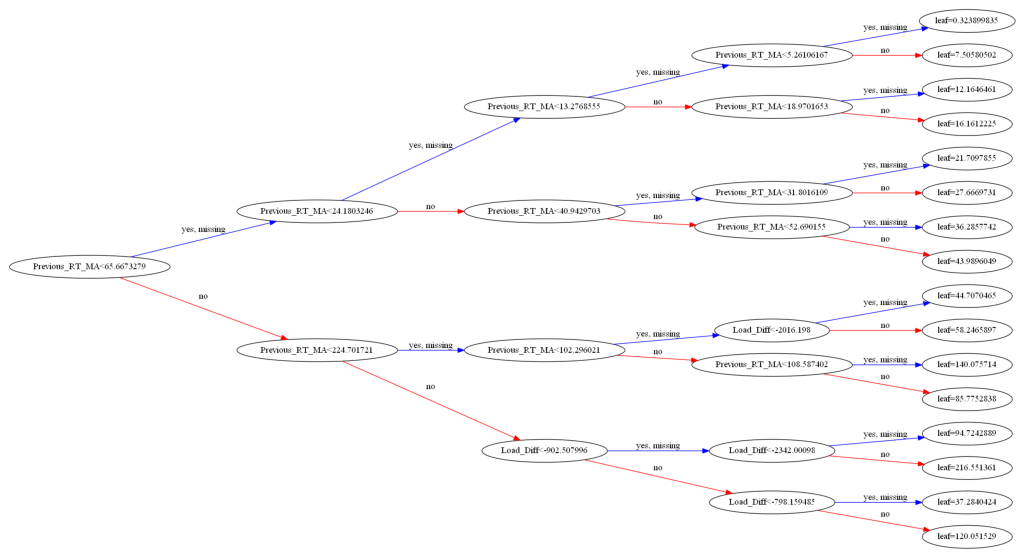

In [51]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0,rankdir='LR')
plt.show()

In [45]:
test = dataset.loc[~dataset['Day'].isin(train_days)].dropna()
X_test = test.iloc[:,0:6]
y_test = test.iloc[:,7]
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.75,
                max_depth = 4, alpha = 10)
xg_reg.fit(X,y)
y_xgb = xg_reg.predict(X_test)
pe(y_xgb, y_test)[pe(y_xgb, y_test)!=np.inf].mean()

7903.233447655286

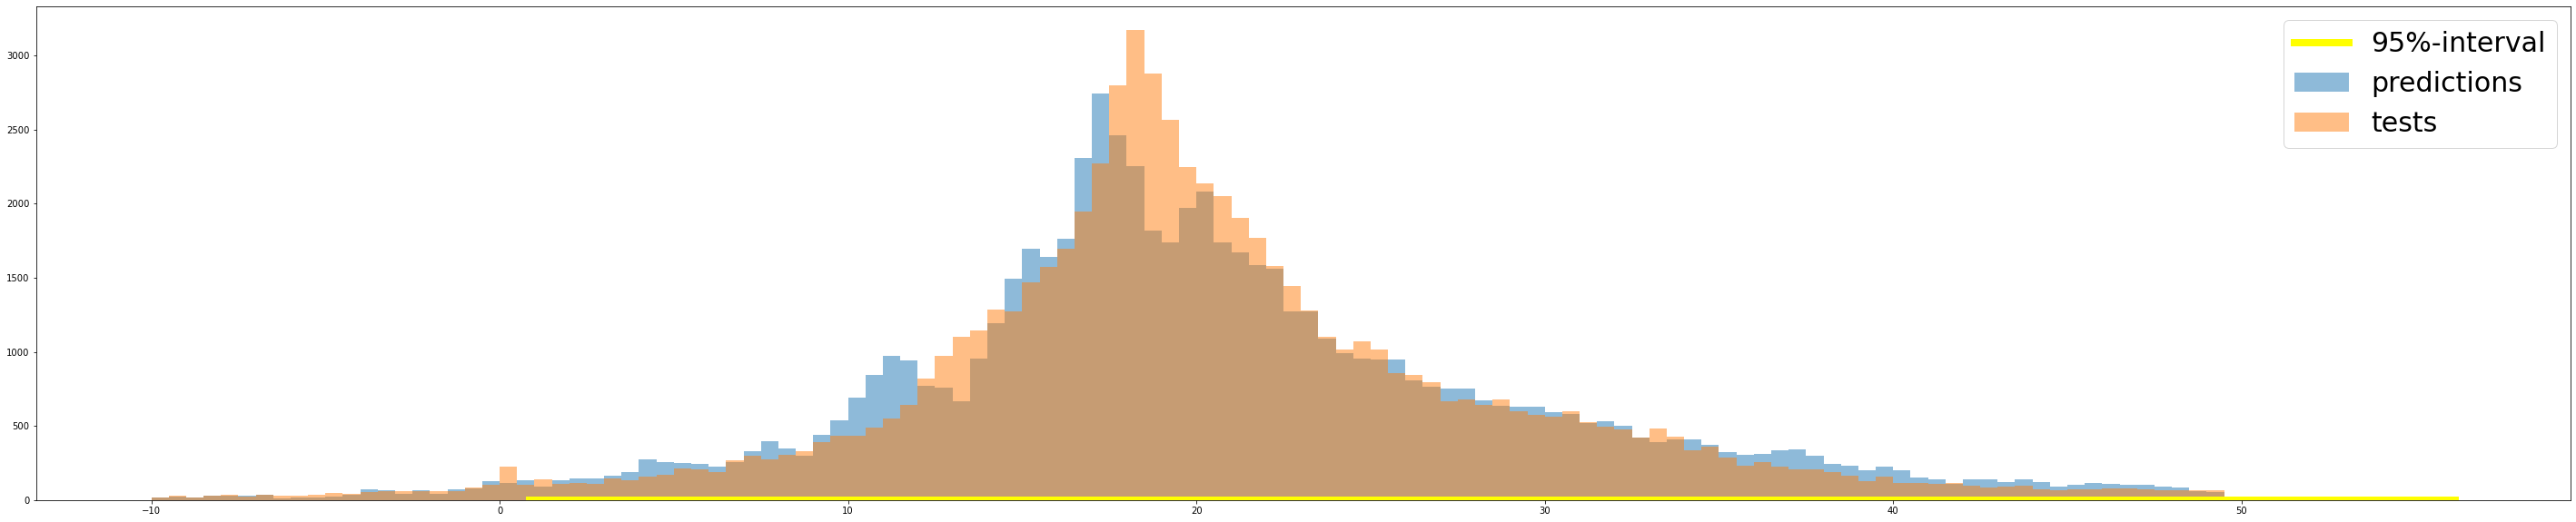

In [58]:
_ = plt.hist(y_xgb,bins=np.arange(-10,50,0.5),alpha=0.5,label='predictions')
_ = plt.hist(y_test,bins=np.arange(-10,50,0.5),alpha=0.5,label='tests')
left = np.percentile(y_test, 2.5)
right = np.percentile(y_test, 97.5)
plt.plot([left, right], [0,0], color='yellow', lw=8,label='95% interval')
plt.legend(prop={'size': 30})

In [47]:
PE = pe(y_xgb, y_test)
left = np.percentile(PE, 2.5)
right = np.percentile(PE, 97.5)
PE[(PE>left)&(PE<right)].mean()

21.8419320921772